In [208]:
# author: TSE, Ho Nam
# student_id: 20423612
import numpy as np
from scipy import sparse
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import nltk
from nltk.corpus import stopwords
import string
import pandas as pd
from matplotlib import pylab as plt

stop_words = set(stopwords.words('english') + list(string.punctuation))

def tokenize(text):
    '''
    :param text: a doc with multiple sentences, type: str
    return a word list, type: list
    https://textminingonline.com/dive-into-nltk-part-ii-sentence-tokenize-and-word-tokenize
    e.g. 
    Input: 'It is a nice day. I am happy.'
    Output: ['it', 'is', 'a', 'nice', 'day', 'i', 'am', 'happy']
    '''
    tokens = []
    # YOUR CODE HERE
    for word in nltk.word_tokenize(text):
        word = word.lower()
        if word not in stop_words and not word.isnumeric():
            tokens.append(word)
    return tokens

def get_bagofwords(data, vocab_dict):
    '''
    :param data: a list of words, type: list
    :param vocab_dict: a dict from words to indices, type: dict
    return a word (sparse) matrix, type: scipy.sparse.csr_matrix
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.lil_matrix.html
    https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html
    '''
    data_matrix = sparse.lil_matrix((len(data), len(vocab_dict)))
    # YOUR CODE HERE
    for i, doc in enumerate(data):
        for word in doc:
            word_idx = vocab_dict.get(word, -1)
            if word_idx != -1:
                data_matrix[i, word_idx] += 1
    data_matrix = data_matrix.tocsr()
    return data_matrix

def filter_words(data_matrix, vocab, count=(3, 25000)):
    """
    This function filters words with too few/too many occurences.
    """
    vocab_cnt = np.array(np.sum(data_matrix, axis=0)).flatten()
    vocab_list = np.array(list(vocab))
    vocab_sel = np.argwhere((count[0] <= vocab_cnt) & (vocab_cnt <= count[1])).flatten() # selector
    return data_matrix[:,vocab_sel], vocab_list[vocab_sel]

def read_data(file_name, vocab=None, mode='test'):
    """
    https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html
    """
    df = pd.read_csv(file_name)
    df['words'] = df['text'].apply(tokenize)

    if vocab is None:
        vocab = set()
        for i in range(len(df)):
            for word in df.iloc[i]['words']:
                vocab.add(word)
    vocab_dict = dict(zip(vocab, range(len(vocab))))

    data_matrix = get_bagofwords(df['words'], vocab_dict)

    # Only filter when training
    if mode=='train':
        data_matrix, vocab = filter_words(data_matrix, vocab)
    
    return df['id'], df['label'], data_matrix, vocab

def normalize(P, alpha=1):
    """
    normalize P to make sure the sum of every row equals to 1
    e.g.
    Input: [1,2,1,2,4]
    Output: [0.1,0.2,0.1,0.2,0.4] (without laplace smoothing) or [0.1333,0.2,0.1333,0.2,0.3333] (with laplace smoothing)
    """
    # YOUR CODE HERE
    K = P.shape[0]
    norm = np.sum(P, axis=0, keepdims=True)
    return (P+alpha) / (norm+alpha*K)
    
def train_NB(data_label, data_matrix, alpha=1):
    '''
    :param data_label: [N], type: list
    :param data_matrix: [N(document_number), V(Vocabulary number)], type:  scipy.sparse.csr_matrix
    return the P(y) (an M array), P(x|y) (a V*M matrix)
    '''
    N = data_matrix.shape[0]
    K = max(data_label) # labels begin with 1
    # YOUR CODE HERE
    data_delta = np.zeros((N, K))
    for i, l in enumerate(data_label):
        data_delta[i, l-1] = 1
    P_y = normalize(np.sum(data_delta, axis=0), alpha)
    P_xy = normalize(data_matrix.T.dot(data_delta), alpha)

    return P_y, P_xy
    
def predict_NB(data_matrix, P_y, P_xy):
    '''
    :param data_matrix: [N(document_number), V(Vocabulary number)], type:  scipy.sparse.csr_matrix
    :param P_y: [M(label number)], type: np.ndarray
    :param P_xy: [V, M], type: np.ndarray
    return data_pre (a N array)
    '''
    # compute the label probabilities using the P(y) and P(x|y) according to the naive Bayes algorithm
    # YOUR CODE HERE
    log_P_y = np.expand_dims(np.log(P_y), axis=0)
    log_P_xy = np.log(P_xy)
    log_P_dy = data_matrix.dot(log_P_xy)
    log_P = log_P_y + log_P_dy
    # get labels for every document by choosing the maximum probability
    # YOUR CODE HERE
    return np.argmax(log_P, axis=1) + 1
    

def evaluate(y_true, y_pre):
    assert len(y_true) == len(y_pre)
    acc = accuracy_score(y_true, y_pre)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pre, average="macro")
    return acc, precision, recall, f1

In [209]:
print('Reading data...')
train_id_list, train_data_label, train_data_matrix, vocab = read_data("data/train.csv", mode='train')
print("Vocabulary Size:", len(vocab))
print("Training Set Size:", len(train_id_list))
test_id_list, _, test_data_matrix, _ = read_data("data/test.csv", vocab)
print("Test Set Size:", len(test_id_list))

Reading data...
Vocabulary Size: 18763
Training Set Size: 16000
Test Set Size: 4491


In [210]:
# Setting up for k-fold cross validation
print('Setting up k-fold...')
k_folds = 10
train_data_label_folds = np.array_split(train_data_label, k_folds)
train_data_matrix_folds = np.array_split(train_data_matrix.A, k_folds)
print('Converting everything back to sparse matrices...')
for i, mat in enumerate(train_data_matrix_folds):
    train_data_matrix_folds[i] = sparse.csr_matrix(mat)

train_data_label_folds = np.array(train_data_label_folds)
train_data_matrix_folds = np.array(train_data_matrix_folds)
    
for i, mat in enumerate(train_data_matrix_folds):
    print(i, mat.shape)

Setting up k-fold...
Converting everything back to sparse matrices...
0 (1600, 18763)
1 (1600, 18763)
2 (1600, 18763)
3 (1600, 18763)
4 (1600, 18763)
5 (1600, 18763)
6 (1600, 18763)
7 (1600, 18763)
8 (1600, 18763)
9 (1600, 18763)


In [217]:
alpha_choices = np.random.uniform(1, 2, 100)
alpha_acc = {}

for alpha in alpha_choices:
    for k in range(k_folds):
        accuracies = []
        for j in range(k_folds): # j storing the set for validation
            b = np.ones(k_folds, dtype=bool) # All true
            b[j] = False # deselect the validation array
            P_y, P_xy = train_NB(train_data_label_folds[b].reshape(-1), \
                sparse.vstack(train_data_matrix_folds[b]), alpha)
            train_data_pre = predict_NB(train_data_matrix_folds[j], P_y, P_xy)
            acc, precision, recall, f1 = evaluate(train_data_label_folds[j], train_data_pre)
            print("alpha: %f\tAccuracy: %f\tPrecision: %f\tRecall: %f\tMacro-F1: %f" % (alpha, acc, precision, recall, f1))
            accuracies.append(acc)
        alpha_acc[alpha] = accuracies

alpha: 1.672927	Accuracy: 0.588125	Precision: 0.526782	Recall: 0.504280	Macro-F1: 0.509597
alpha: 1.672927	Accuracy: 0.561250	Precision: 0.521852	Recall: 0.493297	Macro-F1: 0.495797
alpha: 1.672927	Accuracy: 0.575625	Precision: 0.550014	Recall: 0.504476	Macro-F1: 0.517715
alpha: 1.672927	Accuracy: 0.599375	Precision: 0.514416	Recall: 0.462380	Macro-F1: 0.476656
alpha: 1.672927	Accuracy: 0.588750	Precision: 0.527346	Recall: 0.486902	Macro-F1: 0.489251
alpha: 1.672927	Accuracy: 0.559375	Precision: 0.530776	Recall: 0.460430	Macro-F1: 0.480010
alpha: 1.672927	Accuracy: 0.600625	Precision: 0.567021	Recall: 0.472369	Macro-F1: 0.502834
alpha: 1.672927	Accuracy: 0.560000	Precision: 0.523207	Recall: 0.477344	Macro-F1: 0.485909
alpha: 1.672927	Accuracy: 0.611875	Precision: 0.558957	Recall: 0.504405	Macro-F1: 0.524982
alpha: 1.672927	Accuracy: 0.615625	Precision: 0.505426	Recall: 0.490798	Macro-F1: 0.495653
alpha: 1.672927	Accuracy: 0.588125	Precision: 0.526782	Recall: 0.504280	Macro-F1: 0.509597

alpha: 1.672927	Accuracy: 0.575625	Precision: 0.550014	Recall: 0.504476	Macro-F1: 0.517715
alpha: 1.672927	Accuracy: 0.599375	Precision: 0.514416	Recall: 0.462380	Macro-F1: 0.476656
alpha: 1.672927	Accuracy: 0.588750	Precision: 0.527346	Recall: 0.486902	Macro-F1: 0.489251
alpha: 1.672927	Accuracy: 0.559375	Precision: 0.530776	Recall: 0.460430	Macro-F1: 0.480010
alpha: 1.672927	Accuracy: 0.600625	Precision: 0.567021	Recall: 0.472369	Macro-F1: 0.502834
alpha: 1.672927	Accuracy: 0.560000	Precision: 0.523207	Recall: 0.477344	Macro-F1: 0.485909
alpha: 1.672927	Accuracy: 0.611875	Precision: 0.558957	Recall: 0.504405	Macro-F1: 0.524982
alpha: 1.672927	Accuracy: 0.615625	Precision: 0.505426	Recall: 0.490798	Macro-F1: 0.495653
alpha: 1.051702	Accuracy: 0.590000	Precision: 0.519943	Recall: 0.519133	Macro-F1: 0.517021
alpha: 1.051702	Accuracy: 0.556250	Precision: 0.520331	Recall: 0.516510	Macro-F1: 0.514799
alpha: 1.051702	Accuracy: 0.569375	Precision: 0.528129	Recall: 0.518906	Macro-F1: 0.521420

alpha: 1.051702	Accuracy: 0.598750	Precision: 0.515010	Recall: 0.476666	Macro-F1: 0.488967
alpha: 1.051702	Accuracy: 0.590000	Precision: 0.519307	Recall: 0.513430	Macro-F1: 0.507711
alpha: 1.051702	Accuracy: 0.564375	Precision: 0.524080	Recall: 0.478997	Macro-F1: 0.493556
alpha: 1.051702	Accuracy: 0.602500	Precision: 0.560725	Recall: 0.493935	Macro-F1: 0.519023
alpha: 1.051702	Accuracy: 0.555625	Precision: 0.512870	Recall: 0.489248	Macro-F1: 0.494490
alpha: 1.051702	Accuracy: 0.610000	Precision: 0.554439	Recall: 0.530985	Macro-F1: 0.541474
alpha: 1.051702	Accuracy: 0.603125	Precision: 0.486759	Recall: 0.495668	Macro-F1: 0.490846
alpha: 1.051702	Accuracy: 0.590000	Precision: 0.519943	Recall: 0.519133	Macro-F1: 0.517021
alpha: 1.051702	Accuracy: 0.556250	Precision: 0.520331	Recall: 0.516510	Macro-F1: 0.514799
alpha: 1.051702	Accuracy: 0.569375	Precision: 0.528129	Recall: 0.518906	Macro-F1: 0.521420
alpha: 1.051702	Accuracy: 0.598750	Precision: 0.515010	Recall: 0.476666	Macro-F1: 0.488967

alpha: 1.507900	Accuracy: 0.561875	Precision: 0.525418	Recall: 0.484141	Macro-F1: 0.492739
alpha: 1.507900	Accuracy: 0.612500	Precision: 0.559535	Recall: 0.513104	Macro-F1: 0.531277
alpha: 1.507900	Accuracy: 0.615000	Precision: 0.508105	Recall: 0.498571	Macro-F1: 0.502012
alpha: 1.507900	Accuracy: 0.586875	Precision: 0.517328	Recall: 0.503479	Macro-F1: 0.505934
alpha: 1.507900	Accuracy: 0.558750	Precision: 0.518969	Recall: 0.496414	Macro-F1: 0.499232
alpha: 1.507900	Accuracy: 0.573750	Precision: 0.539480	Recall: 0.506940	Macro-F1: 0.516764
alpha: 1.507900	Accuracy: 0.598750	Precision: 0.514420	Recall: 0.464057	Macro-F1: 0.478320
alpha: 1.507900	Accuracy: 0.588125	Precision: 0.520931	Recall: 0.492285	Macro-F1: 0.492204
alpha: 1.507900	Accuracy: 0.561875	Precision: 0.528074	Recall: 0.465755	Macro-F1: 0.484146
alpha: 1.507900	Accuracy: 0.597500	Precision: 0.557819	Recall: 0.474345	Macro-F1: 0.503161
alpha: 1.507900	Accuracy: 0.561875	Precision: 0.525418	Recall: 0.484141	Macro-F1: 0.492739

alpha: 1.244116	Accuracy: 0.593125	Precision: 0.522790	Recall: 0.515509	Macro-F1: 0.516163
alpha: 1.244116	Accuracy: 0.563750	Precision: 0.529533	Recall: 0.514646	Macro-F1: 0.516428
alpha: 1.244116	Accuracy: 0.574375	Precision: 0.535921	Recall: 0.515772	Macro-F1: 0.522103
alpha: 1.244116	Accuracy: 0.600000	Precision: 0.518304	Recall: 0.472463	Macro-F1: 0.486645
alpha: 1.244116	Accuracy: 0.592500	Precision: 0.523194	Recall: 0.510449	Macro-F1: 0.506814
alpha: 1.244116	Accuracy: 0.563125	Precision: 0.524417	Recall: 0.471242	Macro-F1: 0.487948
alpha: 1.244116	Accuracy: 0.597500	Precision: 0.556980	Recall: 0.483319	Macro-F1: 0.510094
alpha: 1.244116	Accuracy: 0.558750	Precision: 0.516698	Recall: 0.487723	Macro-F1: 0.494024
alpha: 1.244116	Accuracy: 0.613750	Precision: 0.562600	Recall: 0.530228	Macro-F1: 0.544201
alpha: 1.244116	Accuracy: 0.609375	Precision: 0.498136	Recall: 0.500910	Macro-F1: 0.499167
alpha: 1.244116	Accuracy: 0.593125	Precision: 0.522790	Recall: 0.515509	Macro-F1: 0.516163

alpha: 1.439751	Accuracy: 0.587500	Precision: 0.515464	Recall: 0.503921	Macro-F1: 0.505508
alpha: 1.439751	Accuracy: 0.563125	Precision: 0.526888	Recall: 0.505724	Macro-F1: 0.508760
alpha: 1.439751	Accuracy: 0.573125	Precision: 0.536682	Recall: 0.509557	Macro-F1: 0.517845
alpha: 1.439751	Accuracy: 0.598750	Precision: 0.514071	Recall: 0.465038	Macro-F1: 0.479410
alpha: 1.439751	Accuracy: 0.588125	Precision: 0.520815	Recall: 0.495044	Macro-F1: 0.494402
alpha: 1.439751	Accuracy: 0.561250	Precision: 0.523085	Recall: 0.465031	Macro-F1: 0.482364
alpha: 1.439751	Accuracy: 0.598750	Precision: 0.560963	Recall: 0.478395	Macro-F1: 0.507237
alpha: 1.439751	Accuracy: 0.562500	Precision: 0.525981	Recall: 0.486306	Macro-F1: 0.494947
alpha: 1.439751	Accuracy: 0.611250	Precision: 0.555347	Recall: 0.513424	Macro-F1: 0.530311
alpha: 1.439751	Accuracy: 0.613125	Precision: 0.506629	Recall: 0.499477	Macro-F1: 0.502214
alpha: 1.439751	Accuracy: 0.587500	Precision: 0.515464	Recall: 0.503921	Macro-F1: 0.505508

alpha: 1.181048	Accuracy: 0.570000	Precision: 0.530402	Recall: 0.513626	Macro-F1: 0.519167
alpha: 1.181048	Accuracy: 0.597500	Precision: 0.513620	Recall: 0.471879	Macro-F1: 0.485010
alpha: 1.181048	Accuracy: 0.591250	Precision: 0.522300	Recall: 0.512016	Macro-F1: 0.507688
alpha: 1.181048	Accuracy: 0.565625	Precision: 0.527414	Recall: 0.477770	Macro-F1: 0.493711
alpha: 1.181048	Accuracy: 0.598125	Precision: 0.557222	Recall: 0.485043	Macro-F1: 0.511476
alpha: 1.181048	Accuracy: 0.556250	Precision: 0.513221	Recall: 0.486702	Macro-F1: 0.492652
alpha: 1.181048	Accuracy: 0.614375	Precision: 0.563386	Recall: 0.532208	Macro-F1: 0.545725
alpha: 1.181048	Accuracy: 0.606875	Precision: 0.494397	Recall: 0.498669	Macro-F1: 0.496198
alpha: 1.181048	Accuracy: 0.593750	Precision: 0.522277	Recall: 0.517596	Macro-F1: 0.516984
alpha: 1.181048	Accuracy: 0.558750	Precision: 0.523689	Recall: 0.514961	Macro-F1: 0.515095
alpha: 1.181048	Accuracy: 0.570000	Precision: 0.530402	Recall: 0.513626	Macro-F1: 0.519167

alpha: 1.383510	Accuracy: 0.600000	Precision: 0.514310	Recall: 0.465821	Macro-F1: 0.480014
alpha: 1.383510	Accuracy: 0.591250	Precision: 0.524517	Recall: 0.503083	Macro-F1: 0.501404
alpha: 1.383510	Accuracy: 0.562500	Precision: 0.524794	Recall: 0.467186	Macro-F1: 0.484682
alpha: 1.383510	Accuracy: 0.601250	Precision: 0.562901	Recall: 0.482324	Macro-F1: 0.510893
alpha: 1.383510	Accuracy: 0.559375	Precision: 0.523309	Recall: 0.485137	Macro-F1: 0.493024
alpha: 1.383510	Accuracy: 0.611250	Precision: 0.553195	Recall: 0.514277	Macro-F1: 0.530103
alpha: 1.383510	Accuracy: 0.611875	Precision: 0.503144	Recall: 0.498315	Macro-F1: 0.500036
alpha: 1.383510	Accuracy: 0.588750	Precision: 0.516807	Recall: 0.506406	Macro-F1: 0.507706
alpha: 1.383510	Accuracy: 0.562500	Precision: 0.525982	Recall: 0.506877	Macro-F1: 0.509254
alpha: 1.383510	Accuracy: 0.576875	Precision: 0.542040	Recall: 0.515808	Macro-F1: 0.523675
alpha: 1.383510	Accuracy: 0.600000	Precision: 0.514310	Recall: 0.465821	Macro-F1: 0.480014

alpha: 1.053420	Accuracy: 0.564375	Precision: 0.524080	Recall: 0.478997	Macro-F1: 0.493556
alpha: 1.053420	Accuracy: 0.602500	Precision: 0.560725	Recall: 0.493935	Macro-F1: 0.519023
alpha: 1.053420	Accuracy: 0.555625	Precision: 0.512870	Recall: 0.489248	Macro-F1: 0.494490
alpha: 1.053420	Accuracy: 0.610000	Precision: 0.554945	Recall: 0.530985	Macro-F1: 0.541714
alpha: 1.053420	Accuracy: 0.603125	Precision: 0.486759	Recall: 0.495668	Macro-F1: 0.490846
alpha: 1.053420	Accuracy: 0.590625	Precision: 0.520644	Recall: 0.519574	Macro-F1: 0.517563
alpha: 1.053420	Accuracy: 0.556250	Precision: 0.520331	Recall: 0.516510	Macro-F1: 0.514799
alpha: 1.053420	Accuracy: 0.569375	Precision: 0.528129	Recall: 0.518906	Macro-F1: 0.521420
alpha: 1.053420	Accuracy: 0.598750	Precision: 0.515010	Recall: 0.476666	Macro-F1: 0.488967
alpha: 1.053420	Accuracy: 0.589375	Precision: 0.518117	Recall: 0.512096	Macro-F1: 0.506701
alpha: 1.053420	Accuracy: 0.564375	Precision: 0.524080	Recall: 0.478997	Macro-F1: 0.493556

alpha: 1.630953	Accuracy: 0.562500	Precision: 0.527073	Recall: 0.480962	Macro-F1: 0.489848
alpha: 1.630953	Accuracy: 0.613750	Precision: 0.562783	Recall: 0.508797	Macro-F1: 0.529259
alpha: 1.630953	Accuracy: 0.616250	Precision: 0.507416	Recall: 0.492870	Macro-F1: 0.497976
alpha: 1.630953	Accuracy: 0.588125	Precision: 0.525842	Recall: 0.504859	Macro-F1: 0.509962
alpha: 1.630953	Accuracy: 0.559375	Precision: 0.519729	Recall: 0.492315	Macro-F1: 0.494410
alpha: 1.630953	Accuracy: 0.575625	Precision: 0.546319	Recall: 0.504334	Macro-F1: 0.516597
alpha: 1.630953	Accuracy: 0.598750	Precision: 0.514107	Recall: 0.462095	Macro-F1: 0.476397
alpha: 1.630953	Accuracy: 0.590000	Precision: 0.526855	Recall: 0.489227	Macro-F1: 0.491647
alpha: 1.630953	Accuracy: 0.559375	Precision: 0.527550	Recall: 0.460759	Macro-F1: 0.479486
alpha: 1.630953	Accuracy: 0.600000	Precision: 0.565118	Recall: 0.473797	Macro-F1: 0.504037
alpha: 1.630953	Accuracy: 0.562500	Precision: 0.527073	Recall: 0.480962	Macro-F1: 0.489848

alpha: 1.613046	Accuracy: 0.598750	Precision: 0.515885	Recall: 0.463076	Macro-F1: 0.477793
alpha: 1.613046	Accuracy: 0.590000	Precision: 0.528296	Recall: 0.491330	Macro-F1: 0.493986
alpha: 1.613046	Accuracy: 0.560625	Precision: 0.529673	Recall: 0.463272	Macro-F1: 0.482215
alpha: 1.613046	Accuracy: 0.598125	Precision: 0.560297	Recall: 0.471587	Macro-F1: 0.501155
alpha: 1.613046	Accuracy: 0.561250	Precision: 0.524469	Recall: 0.480113	Macro-F1: 0.488864
alpha: 1.613046	Accuracy: 0.613750	Precision: 0.562169	Recall: 0.508797	Macro-F1: 0.529001
alpha: 1.613046	Accuracy: 0.615625	Precision: 0.508176	Recall: 0.495159	Macro-F1: 0.499757
alpha: 1.613046	Accuracy: 0.588125	Precision: 0.525573	Recall: 0.504859	Macro-F1: 0.509701
alpha: 1.613046	Accuracy: 0.560000	Precision: 0.520628	Recall: 0.494372	Macro-F1: 0.496574
alpha: 1.613046	Accuracy: 0.576250	Precision: 0.545742	Recall: 0.504617	Macro-F1: 0.516749
alpha: 1.613046	Accuracy: 0.598750	Precision: 0.515885	Recall: 0.463076	Macro-F1: 0.477793

alpha: 1.021165	Accuracy: 0.598750	Precision: 0.513378	Recall: 0.477434	Macro-F1: 0.489046
alpha: 1.021165	Accuracy: 0.589375	Precision: 0.518192	Recall: 0.514112	Macro-F1: 0.507780
alpha: 1.021165	Accuracy: 0.565625	Precision: 0.525808	Recall: 0.481102	Macro-F1: 0.495710
alpha: 1.021165	Accuracy: 0.603125	Precision: 0.562393	Recall: 0.495462	Macro-F1: 0.520635
alpha: 1.021165	Accuracy: 0.553750	Precision: 0.510549	Recall: 0.488071	Macro-F1: 0.493021
alpha: 1.021165	Accuracy: 0.609375	Precision: 0.553271	Recall: 0.531625	Macro-F1: 0.541280
alpha: 1.021165	Accuracy: 0.602500	Precision: 0.485495	Recall: 0.495639	Macro-F1: 0.490171
alpha: 1.021165	Accuracy: 0.591250	Precision: 0.522292	Recall: 0.522378	Macro-F1: 0.519596
alpha: 1.021165	Accuracy: 0.554375	Precision: 0.518205	Recall: 0.516224	Macro-F1: 0.513523
alpha: 1.021165	Accuracy: 0.568125	Precision: 0.524553	Recall: 0.517913	Macro-F1: 0.519353
alpha: 1.021165	Accuracy: 0.598750	Precision: 0.513378	Recall: 0.477434	Macro-F1: 0.489046

alpha: 1.052947	Accuracy: 0.602500	Precision: 0.560725	Recall: 0.493935	Macro-F1: 0.519023
alpha: 1.052947	Accuracy: 0.555625	Precision: 0.512870	Recall: 0.489248	Macro-F1: 0.494490
alpha: 1.052947	Accuracy: 0.610000	Precision: 0.554945	Recall: 0.530985	Macro-F1: 0.541714
alpha: 1.052947	Accuracy: 0.603125	Precision: 0.486759	Recall: 0.495668	Macro-F1: 0.490846
alpha: 1.052947	Accuracy: 0.590625	Precision: 0.520644	Recall: 0.519574	Macro-F1: 0.517563
alpha: 1.052947	Accuracy: 0.556250	Precision: 0.520331	Recall: 0.516510	Macro-F1: 0.514799
alpha: 1.052947	Accuracy: 0.569375	Precision: 0.528129	Recall: 0.518906	Macro-F1: 0.521420
alpha: 1.052947	Accuracy: 0.598750	Precision: 0.515010	Recall: 0.476666	Macro-F1: 0.488967
alpha: 1.052947	Accuracy: 0.589375	Precision: 0.518117	Recall: 0.512096	Macro-F1: 0.506701
alpha: 1.052947	Accuracy: 0.564375	Precision: 0.524080	Recall: 0.478997	Macro-F1: 0.493556
alpha: 1.052947	Accuracy: 0.602500	Precision: 0.560725	Recall: 0.493935	Macro-F1: 0.519023

alpha: 1.735263	Accuracy: 0.588750	Precision: 0.527594	Recall: 0.503432	Macro-F1: 0.509229
alpha: 1.735263	Accuracy: 0.562500	Precision: 0.520940	Recall: 0.492397	Macro-F1: 0.494452
alpha: 1.735263	Accuracy: 0.575625	Precision: 0.551527	Recall: 0.503080	Macro-F1: 0.517385
alpha: 1.735263	Accuracy: 0.598750	Precision: 0.516846	Recall: 0.461989	Macro-F1: 0.476545
alpha: 1.735263	Accuracy: 0.588125	Precision: 0.528352	Recall: 0.486544	Macro-F1: 0.488938
alpha: 1.735263	Accuracy: 0.559375	Precision: 0.534719	Recall: 0.460430	Macro-F1: 0.480677
alpha: 1.735263	Accuracy: 0.601875	Precision: 0.572942	Recall: 0.473052	Macro-F1: 0.504793
alpha: 1.735263	Accuracy: 0.556250	Precision: 0.520702	Recall: 0.471059	Macro-F1: 0.479723
alpha: 1.735263	Accuracy: 0.611250	Precision: 0.556076	Recall: 0.501661	Macro-F1: 0.522009
alpha: 1.735263	Accuracy: 0.613125	Precision: 0.502185	Recall: 0.486889	Macro-F1: 0.491934
alpha: 1.735263	Accuracy: 0.588750	Precision: 0.527594	Recall: 0.503432	Macro-F1: 0.509229

alpha: 1.735263	Accuracy: 0.588750	Precision: 0.527594	Recall: 0.503432	Macro-F1: 0.509229
alpha: 1.735263	Accuracy: 0.562500	Precision: 0.520940	Recall: 0.492397	Macro-F1: 0.494452
alpha: 1.735263	Accuracy: 0.575625	Precision: 0.551527	Recall: 0.503080	Macro-F1: 0.517385
alpha: 1.735263	Accuracy: 0.598750	Precision: 0.516846	Recall: 0.461989	Macro-F1: 0.476545
alpha: 1.735263	Accuracy: 0.588125	Precision: 0.528352	Recall: 0.486544	Macro-F1: 0.488938
alpha: 1.735263	Accuracy: 0.559375	Precision: 0.534719	Recall: 0.460430	Macro-F1: 0.480677
alpha: 1.735263	Accuracy: 0.601875	Precision: 0.572942	Recall: 0.473052	Macro-F1: 0.504793
alpha: 1.735263	Accuracy: 0.556250	Precision: 0.520702	Recall: 0.471059	Macro-F1: 0.479723
alpha: 1.735263	Accuracy: 0.611250	Precision: 0.556076	Recall: 0.501661	Macro-F1: 0.522009
alpha: 1.735263	Accuracy: 0.613125	Precision: 0.502185	Recall: 0.486889	Macro-F1: 0.491934
alpha: 1.303652	Accuracy: 0.590000	Precision: 0.518187	Recall: 0.509560	Macro-F1: 0.510491

alpha: 1.303652	Accuracy: 0.562500	Precision: 0.527207	Recall: 0.509140	Macro-F1: 0.511297
alpha: 1.303652	Accuracy: 0.573125	Precision: 0.535775	Recall: 0.513390	Macro-F1: 0.520378
alpha: 1.303652	Accuracy: 0.600625	Precision: 0.519168	Recall: 0.470385	Macro-F1: 0.484986
alpha: 1.303652	Accuracy: 0.589375	Precision: 0.519026	Recall: 0.503311	Macro-F1: 0.500501
alpha: 1.303652	Accuracy: 0.563125	Precision: 0.525726	Recall: 0.471144	Macro-F1: 0.488024
alpha: 1.303652	Accuracy: 0.600625	Precision: 0.561522	Recall: 0.484974	Macro-F1: 0.512602
alpha: 1.303652	Accuracy: 0.559375	Precision: 0.518724	Recall: 0.485786	Macro-F1: 0.492755
alpha: 1.303652	Accuracy: 0.613750	Precision: 0.561004	Recall: 0.526690	Macro-F1: 0.541336
alpha: 1.303652	Accuracy: 0.610625	Precision: 0.502246	Recall: 0.497336	Macro-F1: 0.499265
alpha: 1.303652	Accuracy: 0.590000	Precision: 0.518187	Recall: 0.509560	Macro-F1: 0.510491
alpha: 1.303652	Accuracy: 0.562500	Precision: 0.527207	Recall: 0.509140	Macro-F1: 0.511297

alpha: 1.740628	Accuracy: 0.601250	Precision: 0.572580	Recall: 0.472657	Macro-F1: 0.504400
alpha: 1.740628	Accuracy: 0.556250	Precision: 0.520702	Recall: 0.471059	Macro-F1: 0.479723
alpha: 1.740628	Accuracy: 0.611250	Precision: 0.556076	Recall: 0.501661	Macro-F1: 0.522009
alpha: 1.740628	Accuracy: 0.613750	Precision: 0.502448	Recall: 0.487133	Macro-F1: 0.492187
alpha: 1.740628	Accuracy: 0.588750	Precision: 0.528089	Recall: 0.503389	Macro-F1: 0.509301
alpha: 1.740628	Accuracy: 0.563125	Precision: 0.522120	Recall: 0.492725	Macro-F1: 0.495134
alpha: 1.740628	Accuracy: 0.575625	Precision: 0.551493	Recall: 0.503080	Macro-F1: 0.517380
alpha: 1.740628	Accuracy: 0.598125	Precision: 0.516482	Recall: 0.461597	Macro-F1: 0.476135
alpha: 1.740628	Accuracy: 0.588125	Precision: 0.528352	Recall: 0.486544	Macro-F1: 0.488938
alpha: 1.740628	Accuracy: 0.559375	Precision: 0.534719	Recall: 0.460430	Macro-F1: 0.480677
alpha: 1.740628	Accuracy: 0.601250	Precision: 0.572580	Recall: 0.472657	Macro-F1: 0.504400

alpha: 1.491364	Accuracy: 0.563125	Precision: 0.527947	Recall: 0.486151	Macro-F1: 0.495279
alpha: 1.491364	Accuracy: 0.611875	Precision: 0.558115	Recall: 0.512683	Macro-F1: 0.530639
alpha: 1.491364	Accuracy: 0.615000	Precision: 0.508328	Recall: 0.498571	Macro-F1: 0.502200
alpha: 1.491364	Accuracy: 0.586875	Precision: 0.516654	Recall: 0.503479	Macro-F1: 0.505678
alpha: 1.491364	Accuracy: 0.559375	Precision: 0.520655	Recall: 0.497525	Macro-F1: 0.500661
alpha: 1.491364	Accuracy: 0.573125	Precision: 0.537153	Recall: 0.505675	Macro-F1: 0.515151
alpha: 1.491364	Accuracy: 0.598125	Precision: 0.513430	Recall: 0.463772	Macro-F1: 0.477975
alpha: 1.491364	Accuracy: 0.588125	Precision: 0.519407	Recall: 0.492285	Macro-F1: 0.491924
alpha: 1.491364	Accuracy: 0.561250	Precision: 0.526987	Recall: 0.465439	Macro-F1: 0.483661
alpha: 1.491364	Accuracy: 0.598125	Precision: 0.559098	Recall: 0.475652	Macro-F1: 0.504509
alpha: 1.491364	Accuracy: 0.563125	Precision: 0.527947	Recall: 0.486151	Macro-F1: 0.495279

alpha: 1.270700	Accuracy: 0.591250	Precision: 0.519583	Recall: 0.511865	Macro-F1: 0.512713
alpha: 1.270700	Accuracy: 0.563750	Precision: 0.528861	Recall: 0.513254	Macro-F1: 0.515081
alpha: 1.270700	Accuracy: 0.574375	Precision: 0.536868	Recall: 0.514804	Macro-F1: 0.521845
alpha: 1.270700	Accuracy: 0.599375	Precision: 0.515546	Recall: 0.469816	Macro-F1: 0.483723
alpha: 1.270700	Accuracy: 0.592500	Precision: 0.523453	Recall: 0.509588	Macro-F1: 0.506364
alpha: 1.270700	Accuracy: 0.564375	Precision: 0.526334	Recall: 0.471875	Macro-F1: 0.488814
alpha: 1.270700	Accuracy: 0.597500	Precision: 0.557705	Recall: 0.483319	Macro-F1: 0.510325
alpha: 1.270700	Accuracy: 0.559375	Precision: 0.518971	Recall: 0.488050	Macro-F1: 0.494925
alpha: 1.270700	Accuracy: 0.613750	Precision: 0.562169	Recall: 0.527852	Macro-F1: 0.542553
alpha: 1.270700	Accuracy: 0.610625	Precision: 0.503510	Recall: 0.501266	Macro-F1: 0.502036
alpha: 1.270700	Accuracy: 0.591250	Precision: 0.519583	Recall: 0.511865	Macro-F1: 0.512713

alpha: 1.378896	Accuracy: 0.576875	Precision: 0.542040	Recall: 0.515808	Macro-F1: 0.523675
alpha: 1.378896	Accuracy: 0.600625	Precision: 0.516346	Recall: 0.467656	Macro-F1: 0.481738
alpha: 1.378896	Accuracy: 0.591250	Precision: 0.524517	Recall: 0.503083	Macro-F1: 0.501404
alpha: 1.378896	Accuracy: 0.562500	Precision: 0.524233	Recall: 0.467186	Macro-F1: 0.484561
alpha: 1.378896	Accuracy: 0.600625	Precision: 0.561813	Recall: 0.481929	Macro-F1: 0.510269
alpha: 1.378896	Accuracy: 0.558750	Precision: 0.521266	Recall: 0.483953	Macro-F1: 0.491714
alpha: 1.378896	Accuracy: 0.613125	Precision: 0.557485	Recall: 0.519666	Macro-F1: 0.535297
alpha: 1.378896	Accuracy: 0.611875	Precision: 0.503144	Recall: 0.498315	Macro-F1: 0.500036
alpha: 1.378896	Accuracy: 0.589375	Precision: 0.517242	Recall: 0.506848	Macro-F1: 0.508171
alpha: 1.378896	Accuracy: 0.562500	Precision: 0.525982	Recall: 0.506877	Macro-F1: 0.509254
alpha: 1.378896	Accuracy: 0.576875	Precision: 0.542040	Recall: 0.515808	Macro-F1: 0.523675

alpha: 1.453298	Accuracy: 0.560625	Precision: 0.521614	Recall: 0.463979	Macro-F1: 0.481052
alpha: 1.453298	Accuracy: 0.598750	Precision: 0.560963	Recall: 0.478395	Macro-F1: 0.507237
alpha: 1.453298	Accuracy: 0.563125	Precision: 0.527362	Recall: 0.486731	Macro-F1: 0.495491
alpha: 1.453298	Accuracy: 0.611875	Precision: 0.556696	Recall: 0.513845	Macro-F1: 0.530955
alpha: 1.453298	Accuracy: 0.615000	Precision: 0.509127	Recall: 0.500641	Macro-F1: 0.503875
alpha: 1.453298	Accuracy: 0.586875	Precision: 0.514513	Recall: 0.502900	Macro-F1: 0.504515
alpha: 1.453298	Accuracy: 0.563125	Precision: 0.527390	Recall: 0.505724	Macro-F1: 0.508705
alpha: 1.453298	Accuracy: 0.574375	Precision: 0.538686	Recall: 0.510004	Macro-F1: 0.518810
alpha: 1.453298	Accuracy: 0.598750	Precision: 0.515388	Recall: 0.465038	Macro-F1: 0.479587
alpha: 1.453298	Accuracy: 0.586875	Precision: 0.517763	Recall: 0.492491	Macro-F1: 0.491952
alpha: 1.453298	Accuracy: 0.560625	Precision: 0.521614	Recall: 0.463979	Macro-F1: 0.481052

alpha: 1.794476	Accuracy: 0.555000	Precision: 0.519633	Recall: 0.465772	Macro-F1: 0.475217
alpha: 1.794476	Accuracy: 0.612500	Precision: 0.555342	Recall: 0.497708	Macro-F1: 0.518985
alpha: 1.794476	Accuracy: 0.612500	Precision: 0.501294	Recall: 0.481577	Macro-F1: 0.488341
alpha: 1.794476	Accuracy: 0.589375	Precision: 0.528998	Recall: 0.503567	Macro-F1: 0.509746
alpha: 1.794476	Accuracy: 0.563750	Precision: 0.521961	Recall: 0.491161	Macro-F1: 0.493769
alpha: 1.794476	Accuracy: 0.575000	Precision: 0.548327	Recall: 0.499728	Macro-F1: 0.513272
alpha: 1.794476	Accuracy: 0.596250	Precision: 0.513203	Recall: 0.457968	Macro-F1: 0.471810
alpha: 1.794476	Accuracy: 0.588750	Precision: 0.527244	Recall: 0.484143	Macro-F1: 0.487417
alpha: 1.794476	Accuracy: 0.558750	Precision: 0.538813	Recall: 0.460521	Macro-F1: 0.481872
alpha: 1.794476	Accuracy: 0.600000	Precision: 0.571775	Recall: 0.470645	Macro-F1: 0.502457
alpha: 1.794476	Accuracy: 0.555000	Precision: 0.519633	Recall: 0.465772	Macro-F1: 0.475217

alpha: 1.560990	Accuracy: 0.575000	Precision: 0.541759	Recall: 0.505220	Macro-F1: 0.516149
alpha: 1.560990	Accuracy: 0.599375	Precision: 0.518233	Recall: 0.465785	Macro-F1: 0.480585
alpha: 1.560990	Accuracy: 0.589375	Precision: 0.526417	Recall: 0.492734	Macro-F1: 0.493836
alpha: 1.560990	Accuracy: 0.561250	Precision: 0.527960	Recall: 0.463966	Macro-F1: 0.482374
alpha: 1.560990	Accuracy: 0.598125	Precision: 0.558541	Recall: 0.471587	Macro-F1: 0.500799
alpha: 1.560990	Accuracy: 0.560000	Precision: 0.522973	Recall: 0.479941	Macro-F1: 0.488647
alpha: 1.560990	Accuracy: 0.613750	Precision: 0.560950	Recall: 0.511570	Macro-F1: 0.530599
alpha: 1.560990	Accuracy: 0.615000	Precision: 0.508585	Recall: 0.497333	Macro-F1: 0.501479
alpha: 1.560990	Accuracy: 0.588125	Precision: 0.521747	Recall: 0.505481	Macro-F1: 0.508878
alpha: 1.560990	Accuracy: 0.560000	Precision: 0.521540	Recall: 0.495852	Macro-F1: 0.498595
alpha: 1.560990	Accuracy: 0.575000	Precision: 0.541759	Recall: 0.505220	Macro-F1: 0.516149

alpha: 1.263588	Accuracy: 0.600000	Precision: 0.517296	Recall: 0.471082	Macro-F1: 0.485256
alpha: 1.263588	Accuracy: 0.591875	Precision: 0.522446	Recall: 0.509116	Macro-F1: 0.505863
alpha: 1.263588	Accuracy: 0.563750	Precision: 0.526040	Recall: 0.471559	Macro-F1: 0.488543
alpha: 1.263588	Accuracy: 0.597500	Precision: 0.557337	Recall: 0.483319	Macro-F1: 0.510208
alpha: 1.263588	Accuracy: 0.559375	Precision: 0.518054	Recall: 0.488050	Macro-F1: 0.494679
alpha: 1.263588	Accuracy: 0.613750	Precision: 0.561725	Recall: 0.527852	Macro-F1: 0.542417
alpha: 1.263588	Accuracy: 0.610000	Precision: 0.501888	Recall: 0.501022	Macro-F1: 0.501111
alpha: 1.263588	Accuracy: 0.592500	Precision: 0.521751	Recall: 0.514218	Macro-F1: 0.514961
alpha: 1.263588	Accuracy: 0.562500	Precision: 0.527450	Recall: 0.512424	Macro-F1: 0.513954
alpha: 1.263588	Accuracy: 0.573750	Precision: 0.536153	Recall: 0.514514	Macro-F1: 0.521462
alpha: 1.263588	Accuracy: 0.600000	Precision: 0.517296	Recall: 0.471082	Macro-F1: 0.485256

alpha: 1.902739	Accuracy: 0.609375	Precision: 0.547558	Recall: 0.488645	Macro-F1: 0.509315
alpha: 1.902739	Accuracy: 0.615000	Precision: 0.506524	Recall: 0.480910	Macro-F1: 0.489809
alpha: 1.902739	Accuracy: 0.592500	Precision: 0.537136	Recall: 0.505694	Macro-F1: 0.513600
alpha: 1.902739	Accuracy: 0.567500	Precision: 0.527076	Recall: 0.490699	Macro-F1: 0.494592
alpha: 1.902739	Accuracy: 0.572500	Precision: 0.546413	Recall: 0.492091	Macro-F1: 0.505543
alpha: 1.902739	Accuracy: 0.596250	Precision: 0.508065	Recall: 0.454720	Macro-F1: 0.467001
alpha: 1.902739	Accuracy: 0.589375	Precision: 0.530907	Recall: 0.482196	Macro-F1: 0.486443
alpha: 1.902739	Accuracy: 0.558750	Precision: 0.544642	Recall: 0.457306	Macro-F1: 0.481066
alpha: 1.902739	Accuracy: 0.601250	Precision: 0.576972	Recall: 0.469785	Macro-F1: 0.502625
alpha: 1.902739	Accuracy: 0.558125	Precision: 0.524763	Recall: 0.466264	Macro-F1: 0.476816
alpha: 1.902739	Accuracy: 0.609375	Precision: 0.547558	Recall: 0.488645	Macro-F1: 0.509315

alpha: 1.340165	Accuracy: 0.560625	Precision: 0.523743	Recall: 0.505807	Macro-F1: 0.507715
alpha: 1.340165	Accuracy: 0.576250	Precision: 0.540457	Recall: 0.515518	Macro-F1: 0.523023
alpha: 1.340165	Accuracy: 0.600625	Precision: 0.517229	Recall: 0.468530	Macro-F1: 0.482830
alpha: 1.340165	Accuracy: 0.588750	Precision: 0.520042	Recall: 0.501685	Macro-F1: 0.499716
alpha: 1.340165	Accuracy: 0.562500	Precision: 0.524824	Recall: 0.470091	Macro-F1: 0.486941
alpha: 1.340165	Accuracy: 0.598750	Precision: 0.558947	Recall: 0.481655	Macro-F1: 0.509342
alpha: 1.340165	Accuracy: 0.559375	Precision: 0.520574	Recall: 0.485056	Macro-F1: 0.492512
alpha: 1.340165	Accuracy: 0.612500	Precision: 0.557691	Recall: 0.521966	Macro-F1: 0.536805
alpha: 1.340165	Accuracy: 0.611875	Precision: 0.503864	Recall: 0.499552	Macro-F1: 0.501142
alpha: 1.340165	Accuracy: 0.588750	Precision: 0.516964	Recall: 0.507117	Macro-F1: 0.508359
alpha: 1.340165	Accuracy: 0.560625	Precision: 0.523743	Recall: 0.505807	Macro-F1: 0.507715

alpha: 1.730313	Accuracy: 0.575000	Precision: 0.548871	Recall: 0.501814	Macro-F1: 0.515728
alpha: 1.730313	Accuracy: 0.598750	Precision: 0.516846	Recall: 0.461989	Macro-F1: 0.476545
alpha: 1.730313	Accuracy: 0.588125	Precision: 0.528352	Recall: 0.486544	Macro-F1: 0.488938
alpha: 1.730313	Accuracy: 0.560000	Precision: 0.535069	Recall: 0.460796	Macro-F1: 0.481061
alpha: 1.730313	Accuracy: 0.601875	Precision: 0.572942	Recall: 0.473052	Macro-F1: 0.504793
alpha: 1.730313	Accuracy: 0.556250	Precision: 0.520702	Recall: 0.471059	Macro-F1: 0.479723
alpha: 1.730313	Accuracy: 0.611250	Precision: 0.556076	Recall: 0.501661	Macro-F1: 0.522009
alpha: 1.730313	Accuracy: 0.613750	Precision: 0.501910	Recall: 0.487348	Macro-F1: 0.492250
alpha: 1.730313	Accuracy: 0.588750	Precision: 0.527594	Recall: 0.503432	Macro-F1: 0.509229
alpha: 1.730313	Accuracy: 0.561875	Precision: 0.520523	Recall: 0.491983	Macro-F1: 0.494077
alpha: 1.730313	Accuracy: 0.575000	Precision: 0.548871	Recall: 0.501814	Macro-F1: 0.515728

alpha: 1.730313	Accuracy: 0.588125	Precision: 0.528352	Recall: 0.486544	Macro-F1: 0.488938
alpha: 1.730313	Accuracy: 0.560000	Precision: 0.535069	Recall: 0.460796	Macro-F1: 0.481061
alpha: 1.730313	Accuracy: 0.601875	Precision: 0.572942	Recall: 0.473052	Macro-F1: 0.504793
alpha: 1.730313	Accuracy: 0.556250	Precision: 0.520702	Recall: 0.471059	Macro-F1: 0.479723
alpha: 1.730313	Accuracy: 0.611250	Precision: 0.556076	Recall: 0.501661	Macro-F1: 0.522009
alpha: 1.730313	Accuracy: 0.613750	Precision: 0.501910	Recall: 0.487348	Macro-F1: 0.492250
alpha: 1.387565	Accuracy: 0.588750	Precision: 0.516807	Recall: 0.506406	Macro-F1: 0.507706
alpha: 1.387565	Accuracy: 0.563125	Precision: 0.527512	Recall: 0.507988	Macro-F1: 0.510517
alpha: 1.387565	Accuracy: 0.576875	Precision: 0.542040	Recall: 0.515808	Macro-F1: 0.523675
alpha: 1.387565	Accuracy: 0.600000	Precision: 0.514174	Recall: 0.465821	Macro-F1: 0.480145
alpha: 1.387565	Accuracy: 0.591250	Precision: 0.524517	Recall: 0.503083	Macro-F1: 0.501404

alpha: 1.387565	Accuracy: 0.560000	Precision: 0.523604	Recall: 0.485464	Macro-F1: 0.493314
alpha: 1.387565	Accuracy: 0.610625	Precision: 0.552931	Recall: 0.514010	Macro-F1: 0.529834
alpha: 1.387565	Accuracy: 0.611875	Precision: 0.503144	Recall: 0.498315	Macro-F1: 0.500036
alpha: 1.387565	Accuracy: 0.588750	Precision: 0.516807	Recall: 0.506406	Macro-F1: 0.507706
alpha: 1.387565	Accuracy: 0.563125	Precision: 0.527512	Recall: 0.507988	Macro-F1: 0.510517
alpha: 1.387565	Accuracy: 0.576875	Precision: 0.542040	Recall: 0.515808	Macro-F1: 0.523675
alpha: 1.387565	Accuracy: 0.600000	Precision: 0.514174	Recall: 0.465821	Macro-F1: 0.480145
alpha: 1.387565	Accuracy: 0.591250	Precision: 0.524517	Recall: 0.503083	Macro-F1: 0.501404
alpha: 1.387565	Accuracy: 0.562500	Precision: 0.524794	Recall: 0.467186	Macro-F1: 0.484682
alpha: 1.387565	Accuracy: 0.601250	Precision: 0.562901	Recall: 0.482324	Macro-F1: 0.510893
alpha: 1.387565	Accuracy: 0.560000	Precision: 0.523604	Recall: 0.485464	Macro-F1: 0.493314

alpha: 1.301665	Accuracy: 0.610625	Precision: 0.502246	Recall: 0.497336	Macro-F1: 0.499265
alpha: 1.301665	Accuracy: 0.590000	Precision: 0.517902	Recall: 0.509560	Macro-F1: 0.510420
alpha: 1.301665	Accuracy: 0.562500	Precision: 0.527207	Recall: 0.509140	Macro-F1: 0.511297
alpha: 1.301665	Accuracy: 0.573125	Precision: 0.535775	Recall: 0.513390	Macro-F1: 0.520378
alpha: 1.301665	Accuracy: 0.600625	Precision: 0.519168	Recall: 0.470385	Macro-F1: 0.484986
alpha: 1.301665	Accuracy: 0.589375	Precision: 0.519026	Recall: 0.503311	Macro-F1: 0.500501
alpha: 1.301665	Accuracy: 0.563125	Precision: 0.525676	Recall: 0.471144	Macro-F1: 0.488030
alpha: 1.301665	Accuracy: 0.600000	Precision: 0.561240	Recall: 0.484686	Macro-F1: 0.512340
alpha: 1.301665	Accuracy: 0.559375	Precision: 0.518724	Recall: 0.485786	Macro-F1: 0.492755
alpha: 1.301665	Accuracy: 0.613750	Precision: 0.561004	Recall: 0.526690	Macro-F1: 0.541336
alpha: 1.301665	Accuracy: 0.610625	Precision: 0.502246	Recall: 0.497336	Macro-F1: 0.499265

alpha: 1.909686	Accuracy: 0.567500	Precision: 0.527076	Recall: 0.490699	Macro-F1: 0.494592
alpha: 1.909686	Accuracy: 0.572500	Precision: 0.546413	Recall: 0.492091	Macro-F1: 0.505543
alpha: 1.909686	Accuracy: 0.595625	Precision: 0.507702	Recall: 0.454329	Macro-F1: 0.466593
alpha: 1.909686	Accuracy: 0.589375	Precision: 0.531122	Recall: 0.482196	Macro-F1: 0.486593
alpha: 1.909686	Accuracy: 0.558750	Precision: 0.544642	Recall: 0.457306	Macro-F1: 0.481066
alpha: 1.909686	Accuracy: 0.600625	Precision: 0.576356	Recall: 0.468258	Macro-F1: 0.501331
alpha: 1.909686	Accuracy: 0.556875	Precision: 0.524364	Recall: 0.464603	Macro-F1: 0.475169
alpha: 1.909686	Accuracy: 0.609375	Precision: 0.547558	Recall: 0.488645	Macro-F1: 0.509315
alpha: 1.909686	Accuracy: 0.615000	Precision: 0.506968	Recall: 0.480910	Macro-F1: 0.489888
alpha: 1.909686	Accuracy: 0.591875	Precision: 0.535737	Recall: 0.504674	Macro-F1: 0.512338
alpha: 1.909686	Accuracy: 0.567500	Precision: 0.527076	Recall: 0.490699	Macro-F1: 0.494592

alpha: 1.689055	Accuracy: 0.559375	Precision: 0.530776	Recall: 0.460430	Macro-F1: 0.480010
alpha: 1.689055	Accuracy: 0.600000	Precision: 0.565648	Recall: 0.470842	Macro-F1: 0.501416
alpha: 1.689055	Accuracy: 0.559375	Precision: 0.523335	Recall: 0.476339	Macro-F1: 0.484960
alpha: 1.689055	Accuracy: 0.611250	Precision: 0.557787	Recall: 0.502977	Macro-F1: 0.523558
alpha: 1.689055	Accuracy: 0.615000	Precision: 0.503905	Recall: 0.489074	Macro-F1: 0.494144
alpha: 1.689055	Accuracy: 0.590000	Precision: 0.529278	Recall: 0.506322	Macro-F1: 0.511855
alpha: 1.689055	Accuracy: 0.561250	Precision: 0.520494	Recall: 0.491655	Macro-F1: 0.493904
alpha: 1.689055	Accuracy: 0.575000	Precision: 0.549299	Recall: 0.504051	Macro-F1: 0.517407
alpha: 1.689055	Accuracy: 0.599375	Precision: 0.514502	Recall: 0.462380	Macro-F1: 0.476664
alpha: 1.689055	Accuracy: 0.588125	Precision: 0.526918	Recall: 0.486430	Macro-F1: 0.488836
alpha: 1.689055	Accuracy: 0.559375	Precision: 0.530776	Recall: 0.460430	Macro-F1: 0.480010

alpha: 1.198538	Accuracy: 0.613750	Precision: 0.562600	Recall: 0.530228	Macro-F1: 0.544201
alpha: 1.198538	Accuracy: 0.608125	Precision: 0.497554	Recall: 0.500637	Macro-F1: 0.498777
alpha: 1.198538	Accuracy: 0.592500	Precision: 0.520785	Recall: 0.516134	Macro-F1: 0.515493
alpha: 1.198538	Accuracy: 0.560625	Precision: 0.526034	Recall: 0.515085	Macro-F1: 0.515955
alpha: 1.198538	Accuracy: 0.572500	Precision: 0.533785	Recall: 0.515328	Macro-F1: 0.521314
alpha: 1.198538	Accuracy: 0.598750	Precision: 0.515433	Recall: 0.472661	Macro-F1: 0.486158
alpha: 1.198538	Accuracy: 0.590625	Precision: 0.521926	Recall: 0.510390	Macro-F1: 0.506405
alpha: 1.198538	Accuracy: 0.563125	Precision: 0.522862	Recall: 0.473839	Macro-F1: 0.489350
alpha: 1.198538	Accuracy: 0.598125	Precision: 0.557568	Recall: 0.485043	Macro-F1: 0.511589
alpha: 1.198538	Accuracy: 0.558125	Precision: 0.515807	Recall: 0.487976	Macro-F1: 0.494082
alpha: 1.198538	Accuracy: 0.613750	Precision: 0.562600	Recall: 0.530228	Macro-F1: 0.544201

alpha: 1.332891	Accuracy: 0.600625	Precision: 0.516882	Recall: 0.468637	Macro-F1: 0.482767
alpha: 1.332891	Accuracy: 0.589375	Precision: 0.519975	Recall: 0.503311	Macro-F1: 0.500854
alpha: 1.332891	Accuracy: 0.562500	Precision: 0.524824	Recall: 0.470091	Macro-F1: 0.486941
alpha: 1.332891	Accuracy: 0.599375	Precision: 0.560323	Recall: 0.482962	Macro-F1: 0.510728
alpha: 1.332891	Accuracy: 0.558750	Precision: 0.519713	Recall: 0.484631	Macro-F1: 0.492024
alpha: 1.332891	Accuracy: 0.613125	Precision: 0.558716	Recall: 0.523394	Macro-F1: 0.538197
alpha: 1.332891	Accuracy: 0.611875	Precision: 0.504887	Recall: 0.500574	Macro-F1: 0.502195
alpha: 1.332891	Accuracy: 0.588750	Precision: 0.516964	Recall: 0.507117	Macro-F1: 0.508359
alpha: 1.332891	Accuracy: 0.560625	Precision: 0.523743	Recall: 0.505807	Macro-F1: 0.507715
alpha: 1.332891	Accuracy: 0.576250	Precision: 0.539935	Recall: 0.515518	Macro-F1: 0.522924
alpha: 1.332891	Accuracy: 0.600625	Precision: 0.516882	Recall: 0.468637	Macro-F1: 0.482767

alpha: 1.012940	Accuracy: 0.590000	Precision: 0.519715	Recall: 0.515332	Macro-F1: 0.509207
alpha: 1.012940	Accuracy: 0.566250	Precision: 0.527632	Recall: 0.483230	Macro-F1: 0.497586
alpha: 1.012940	Accuracy: 0.604375	Precision: 0.563929	Recall: 0.498493	Macro-F1: 0.523301
alpha: 1.012940	Accuracy: 0.553750	Precision: 0.509753	Recall: 0.488071	Macro-F1: 0.492799
alpha: 1.012940	Accuracy: 0.610000	Precision: 0.554584	Recall: 0.533053	Macro-F1: 0.542691
alpha: 1.012940	Accuracy: 0.603125	Precision: 0.486654	Recall: 0.496905	Macro-F1: 0.491383
alpha: 1.012940	Accuracy: 0.590625	Precision: 0.521586	Recall: 0.521937	Macro-F1: 0.519050
alpha: 1.012940	Accuracy: 0.555000	Precision: 0.519015	Recall: 0.517335	Macro-F1: 0.514631
alpha: 1.012940	Accuracy: 0.568125	Precision: 0.524145	Recall: 0.517778	Macro-F1: 0.519149
alpha: 1.012940	Accuracy: 0.599375	Precision: 0.514883	Recall: 0.478700	Macro-F1: 0.490460
alpha: 1.012940	Accuracy: 0.590000	Precision: 0.519715	Recall: 0.515332	Macro-F1: 0.509207

alpha: 1.033100	Accuracy: 0.603125	Precision: 0.562393	Recall: 0.495462	Macro-F1: 0.520635
alpha: 1.033100	Accuracy: 0.553750	Precision: 0.511370	Recall: 0.488071	Macro-F1: 0.493246
alpha: 1.033100	Accuracy: 0.609375	Precision: 0.553167	Recall: 0.530564	Macro-F1: 0.540691
alpha: 1.033100	Accuracy: 0.603125	Precision: 0.486081	Recall: 0.495883	Macro-F1: 0.490577
alpha: 1.033100	Accuracy: 0.591250	Precision: 0.521364	Recall: 0.521668	Macro-F1: 0.518820
alpha: 1.033100	Accuracy: 0.554375	Precision: 0.518565	Recall: 0.516224	Macro-F1: 0.513610
alpha: 1.033100	Accuracy: 0.569375	Precision: 0.527554	Recall: 0.518906	Macro-F1: 0.521259
alpha: 1.033100	Accuracy: 0.599375	Precision: 0.514613	Recall: 0.477826	Macro-F1: 0.489669
alpha: 1.033100	Accuracy: 0.589375	Precision: 0.518479	Recall: 0.514112	Macro-F1: 0.508042
alpha: 1.033100	Accuracy: 0.564375	Precision: 0.523596	Recall: 0.478997	Macro-F1: 0.493445
alpha: 1.033100	Accuracy: 0.603125	Precision: 0.562393	Recall: 0.495462	Macro-F1: 0.520635

alpha: 1.739702	Accuracy: 0.601250	Precision: 0.572580	Recall: 0.472657	Macro-F1: 0.504400
alpha: 1.739702	Accuracy: 0.556250	Precision: 0.520702	Recall: 0.471059	Macro-F1: 0.479723
alpha: 1.739702	Accuracy: 0.611250	Precision: 0.556076	Recall: 0.501661	Macro-F1: 0.522009
alpha: 1.739702	Accuracy: 0.613750	Precision: 0.502448	Recall: 0.487133	Macro-F1: 0.492187
alpha: 1.739702	Accuracy: 0.588750	Precision: 0.528089	Recall: 0.503389	Macro-F1: 0.509301
alpha: 1.739702	Accuracy: 0.563125	Precision: 0.522120	Recall: 0.492725	Macro-F1: 0.495134
alpha: 1.739702	Accuracy: 0.575625	Precision: 0.551493	Recall: 0.503080	Macro-F1: 0.517380
alpha: 1.739702	Accuracy: 0.598125	Precision: 0.516482	Recall: 0.461597	Macro-F1: 0.476135
alpha: 1.739702	Accuracy: 0.588125	Precision: 0.528352	Recall: 0.486544	Macro-F1: 0.488938
alpha: 1.739702	Accuracy: 0.559375	Precision: 0.534719	Recall: 0.460430	Macro-F1: 0.480677
alpha: 1.739702	Accuracy: 0.601250	Precision: 0.572580	Recall: 0.472657	Macro-F1: 0.504400

alpha: 1.067991	Accuracy: 0.555625	Precision: 0.512870	Recall: 0.489248	Macro-F1: 0.494490
alpha: 1.067991	Accuracy: 0.610000	Precision: 0.554945	Recall: 0.530985	Macro-F1: 0.541714
alpha: 1.067991	Accuracy: 0.603750	Precision: 0.489687	Recall: 0.497392	Macro-F1: 0.493206
alpha: 1.067991	Accuracy: 0.590625	Precision: 0.520905	Recall: 0.519574	Macro-F1: 0.517633
alpha: 1.067991	Accuracy: 0.558125	Precision: 0.522020	Recall: 0.517755	Macro-F1: 0.516306
alpha: 1.067991	Accuracy: 0.570000	Precision: 0.527772	Recall: 0.518364	Macro-F1: 0.520880
alpha: 1.067991	Accuracy: 0.600000	Precision: 0.514946	Recall: 0.476468	Macro-F1: 0.488825
alpha: 1.067991	Accuracy: 0.588750	Precision: 0.517670	Recall: 0.511624	Macro-F1: 0.506269
alpha: 1.067991	Accuracy: 0.565000	Precision: 0.524379	Recall: 0.479313	Macro-F1: 0.493830
alpha: 1.067991	Accuracy: 0.602500	Precision: 0.562684	Recall: 0.494155	Macro-F1: 0.519769
alpha: 1.067991	Accuracy: 0.555625	Precision: 0.512870	Recall: 0.489248	Macro-F1: 0.494490

alpha: 1.892420	Accuracy: 0.597500	Precision: 0.513514	Recall: 0.457252	Macro-F1: 0.470632
alpha: 1.892420	Accuracy: 0.589375	Precision: 0.530696	Recall: 0.482196	Macro-F1: 0.486296
alpha: 1.892420	Accuracy: 0.558750	Precision: 0.544642	Recall: 0.457306	Macro-F1: 0.481066
alpha: 1.892420	Accuracy: 0.600625	Precision: 0.576709	Recall: 0.469497	Macro-F1: 0.502367
alpha: 1.892420	Accuracy: 0.558750	Precision: 0.526721	Recall: 0.467269	Macro-F1: 0.478243
alpha: 1.892420	Accuracy: 0.609375	Precision: 0.547558	Recall: 0.488645	Macro-F1: 0.509315
alpha: 1.892420	Accuracy: 0.615000	Precision: 0.506524	Recall: 0.480910	Macro-F1: 0.489809
alpha: 1.892420	Accuracy: 0.591875	Precision: 0.535288	Recall: 0.504404	Macro-F1: 0.512085
alpha: 1.892420	Accuracy: 0.567500	Precision: 0.526696	Recall: 0.491483	Macro-F1: 0.495166
alpha: 1.892420	Accuracy: 0.573125	Precision: 0.546415	Recall: 0.493357	Macro-F1: 0.506518
alpha: 1.892420	Accuracy: 0.597500	Precision: 0.513514	Recall: 0.457252	Macro-F1: 0.470632

alpha: 1.356657	Accuracy: 0.589375	Precision: 0.520549	Recall: 0.501208	Macro-F1: 0.499245
alpha: 1.356657	Accuracy: 0.562500	Precision: 0.525331	Recall: 0.470091	Macro-F1: 0.487056
alpha: 1.356657	Accuracy: 0.600000	Precision: 0.561062	Recall: 0.482445	Macro-F1: 0.510510
alpha: 1.356657	Accuracy: 0.559375	Precision: 0.521189	Recall: 0.485056	Macro-F1: 0.492683
alpha: 1.356657	Accuracy: 0.612500	Precision: 0.558230	Recall: 0.521966	Macro-F1: 0.537059
alpha: 1.356657	Accuracy: 0.611875	Precision: 0.503719	Recall: 0.499337	Macro-F1: 0.500956
alpha: 1.356657	Accuracy: 0.588125	Precision: 0.515768	Recall: 0.506097	Macro-F1: 0.507214
alpha: 1.356657	Accuracy: 0.561250	Precision: 0.524677	Recall: 0.506134	Macro-F1: 0.508366
alpha: 1.356657	Accuracy: 0.576875	Precision: 0.541362	Recall: 0.515943	Macro-F1: 0.523521
alpha: 1.356657	Accuracy: 0.601250	Precision: 0.518252	Recall: 0.468922	Macro-F1: 0.483333
alpha: 1.356657	Accuracy: 0.589375	Precision: 0.520549	Recall: 0.501208	Macro-F1: 0.499245

alpha: 1.356657	Accuracy: 0.589375	Precision: 0.520549	Recall: 0.501208	Macro-F1: 0.499245
alpha: 1.356657	Accuracy: 0.562500	Precision: 0.525331	Recall: 0.470091	Macro-F1: 0.487056
alpha: 1.356657	Accuracy: 0.600000	Precision: 0.561062	Recall: 0.482445	Macro-F1: 0.510510
alpha: 1.356657	Accuracy: 0.559375	Precision: 0.521189	Recall: 0.485056	Macro-F1: 0.492683
alpha: 1.356657	Accuracy: 0.612500	Precision: 0.558230	Recall: 0.521966	Macro-F1: 0.537059
alpha: 1.356657	Accuracy: 0.611875	Precision: 0.503719	Recall: 0.499337	Macro-F1: 0.500956
alpha: 1.678031	Accuracy: 0.588750	Precision: 0.527210	Recall: 0.504722	Macro-F1: 0.510056
alpha: 1.678031	Accuracy: 0.561875	Precision: 0.522450	Recall: 0.493712	Macro-F1: 0.496294
alpha: 1.678031	Accuracy: 0.575625	Precision: 0.549696	Recall: 0.504476	Macro-F1: 0.517803
alpha: 1.678031	Accuracy: 0.599375	Precision: 0.514416	Recall: 0.462380	Macro-F1: 0.476656
alpha: 1.678031	Accuracy: 0.588125	Precision: 0.526918	Recall: 0.486430	Macro-F1: 0.488836

alpha: 1.678031	Accuracy: 0.560000	Precision: 0.524294	Recall: 0.477344	Macro-F1: 0.486163
alpha: 1.678031	Accuracy: 0.611875	Precision: 0.558957	Recall: 0.504405	Macro-F1: 0.524982
alpha: 1.678031	Accuracy: 0.615000	Precision: 0.503905	Recall: 0.489074	Macro-F1: 0.494144
alpha: 1.678031	Accuracy: 0.588750	Precision: 0.527210	Recall: 0.504722	Macro-F1: 0.510056
alpha: 1.678031	Accuracy: 0.561875	Precision: 0.522450	Recall: 0.493712	Macro-F1: 0.496294
alpha: 1.678031	Accuracy: 0.575625	Precision: 0.549696	Recall: 0.504476	Macro-F1: 0.517803
alpha: 1.678031	Accuracy: 0.599375	Precision: 0.514416	Recall: 0.462380	Macro-F1: 0.476656
alpha: 1.678031	Accuracy: 0.588125	Precision: 0.526918	Recall: 0.486430	Macro-F1: 0.488836
alpha: 1.678031	Accuracy: 0.559375	Precision: 0.530776	Recall: 0.460430	Macro-F1: 0.480010
alpha: 1.678031	Accuracy: 0.600625	Precision: 0.567021	Recall: 0.472369	Macro-F1: 0.502834
alpha: 1.678031	Accuracy: 0.560000	Precision: 0.524294	Recall: 0.477344	Macro-F1: 0.486163

alpha: 1.049672	Accuracy: 0.590000	Precision: 0.519943	Recall: 0.519133	Macro-F1: 0.517021
alpha: 1.049672	Accuracy: 0.556250	Precision: 0.520331	Recall: 0.516510	Macro-F1: 0.514799
alpha: 1.049672	Accuracy: 0.569375	Precision: 0.528129	Recall: 0.518906	Macro-F1: 0.521420
alpha: 1.049672	Accuracy: 0.598125	Precision: 0.514147	Recall: 0.476275	Macro-F1: 0.488446
alpha: 1.049672	Accuracy: 0.590000	Precision: 0.519307	Recall: 0.513430	Macro-F1: 0.507711
alpha: 1.049672	Accuracy: 0.565000	Precision: 0.524434	Recall: 0.479363	Macro-F1: 0.493944
alpha: 1.049672	Accuracy: 0.602500	Precision: 0.560725	Recall: 0.493935	Macro-F1: 0.519023
alpha: 1.049672	Accuracy: 0.555625	Precision: 0.512870	Recall: 0.489248	Macro-F1: 0.494490
alpha: 1.049672	Accuracy: 0.610000	Precision: 0.554439	Recall: 0.530985	Macro-F1: 0.541474
alpha: 1.049672	Accuracy: 0.603750	Precision: 0.486982	Recall: 0.496127	Macro-F1: 0.491159
alpha: 1.049672	Accuracy: 0.590000	Precision: 0.519943	Recall: 0.519133	Macro-F1: 0.517021

alpha: 1.358642	Accuracy: 0.601250	Precision: 0.518252	Recall: 0.468922	Macro-F1: 0.483333
alpha: 1.358642	Accuracy: 0.589375	Precision: 0.520549	Recall: 0.501208	Macro-F1: 0.499245
alpha: 1.358642	Accuracy: 0.563125	Precision: 0.526253	Recall: 0.470457	Macro-F1: 0.487556
alpha: 1.358642	Accuracy: 0.600000	Precision: 0.561062	Recall: 0.482445	Macro-F1: 0.510510
alpha: 1.358642	Accuracy: 0.558750	Precision: 0.519749	Recall: 0.484051	Macro-F1: 0.491430
alpha: 1.358642	Accuracy: 0.612500	Precision: 0.558230	Recall: 0.521966	Macro-F1: 0.537059
alpha: 1.358642	Accuracy: 0.611875	Precision: 0.503719	Recall: 0.499337	Macro-F1: 0.500956
alpha: 1.358642	Accuracy: 0.588750	Precision: 0.516573	Recall: 0.506538	Macro-F1: 0.507749
alpha: 1.358642	Accuracy: 0.561875	Precision: 0.524937	Recall: 0.506462	Macro-F1: 0.508692
alpha: 1.358642	Accuracy: 0.576250	Precision: 0.540959	Recall: 0.515518	Macro-F1: 0.523122
alpha: 1.358642	Accuracy: 0.601250	Precision: 0.518252	Recall: 0.468922	Macro-F1: 0.483333

alpha: 1.114713	Accuracy: 0.564375	Precision: 0.523264	Recall: 0.477755	Macro-F1: 0.492176
alpha: 1.114713	Accuracy: 0.601250	Precision: 0.561765	Recall: 0.492340	Macro-F1: 0.518243
alpha: 1.114713	Accuracy: 0.557500	Precision: 0.516469	Recall: 0.490424	Macro-F1: 0.496242
alpha: 1.114713	Accuracy: 0.610625	Precision: 0.554398	Recall: 0.528023	Macro-F1: 0.539698
alpha: 1.114713	Accuracy: 0.605625	Precision: 0.493829	Recall: 0.498771	Macro-F1: 0.496024
alpha: 1.114713	Accuracy: 0.591250	Precision: 0.520623	Recall: 0.518456	Macro-F1: 0.516796
alpha: 1.114713	Accuracy: 0.559375	Precision: 0.523620	Recall: 0.516768	Macro-F1: 0.516281
alpha: 1.114713	Accuracy: 0.566250	Precision: 0.524444	Recall: 0.511208	Macro-F1: 0.515533
alpha: 1.114713	Accuracy: 0.598125	Precision: 0.510749	Recall: 0.472102	Macro-F1: 0.484368
alpha: 1.114713	Accuracy: 0.591875	Precision: 0.522576	Recall: 0.514097	Macro-F1: 0.509314
alpha: 1.114713	Accuracy: 0.564375	Precision: 0.523264	Recall: 0.477755	Macro-F1: 0.492176

alpha: 1.814037	Accuracy: 0.612500	Precision: 0.556641	Recall: 0.497708	Macro-F1: 0.519225
alpha: 1.814037	Accuracy: 0.613750	Precision: 0.501487	Recall: 0.481044	Macro-F1: 0.488141
alpha: 1.814037	Accuracy: 0.590000	Precision: 0.530723	Recall: 0.503965	Macro-F1: 0.510602
alpha: 1.814037	Accuracy: 0.563750	Precision: 0.522274	Recall: 0.490215	Macro-F1: 0.493010
alpha: 1.814037	Accuracy: 0.573750	Precision: 0.546714	Recall: 0.497338	Macro-F1: 0.511016
alpha: 1.814037	Accuracy: 0.596875	Precision: 0.514063	Recall: 0.458822	Macro-F1: 0.472442
alpha: 1.814037	Accuracy: 0.588750	Precision: 0.528437	Recall: 0.483281	Macro-F1: 0.486982
alpha: 1.814037	Accuracy: 0.558750	Precision: 0.537791	Recall: 0.458710	Macro-F1: 0.480229
alpha: 1.814037	Accuracy: 0.600625	Precision: 0.571799	Recall: 0.469604	Macro-F1: 0.501515
alpha: 1.814037	Accuracy: 0.555000	Precision: 0.519633	Recall: 0.465772	Macro-F1: 0.475217
alpha: 1.814037	Accuracy: 0.612500	Precision: 0.556641	Recall: 0.497708	Macro-F1: 0.519225

alpha: 1.870704	Accuracy: 0.573125	Precision: 0.545761	Recall: 0.494055	Macro-F1: 0.507490
alpha: 1.870704	Accuracy: 0.598125	Precision: 0.514409	Recall: 0.459086	Macro-F1: 0.472021
alpha: 1.870704	Accuracy: 0.588125	Precision: 0.529141	Recall: 0.481655	Macro-F1: 0.485532
alpha: 1.870704	Accuracy: 0.560000	Precision: 0.546491	Recall: 0.458724	Macro-F1: 0.482797
alpha: 1.870704	Accuracy: 0.601250	Precision: 0.577069	Recall: 0.469892	Macro-F1: 0.502760
alpha: 1.870704	Accuracy: 0.557500	Precision: 0.525927	Recall: 0.467373	Macro-F1: 0.477850
alpha: 1.870704	Accuracy: 0.610625	Precision: 0.551260	Recall: 0.492208	Macro-F1: 0.513134
alpha: 1.870704	Accuracy: 0.615000	Precision: 0.505571	Recall: 0.480910	Macro-F1: 0.489469
alpha: 1.870704	Accuracy: 0.590625	Precision: 0.532687	Recall: 0.503653	Macro-F1: 0.510870
alpha: 1.870704	Accuracy: 0.566875	Precision: 0.527232	Recall: 0.491940	Macro-F1: 0.495628
alpha: 1.870704	Accuracy: 0.573125	Precision: 0.545761	Recall: 0.494055	Macro-F1: 0.507490

alpha: 1.530052	Accuracy: 0.597500	Precision: 0.557163	Recall: 0.473433	Macro-F1: 0.502204
alpha: 1.530052	Accuracy: 0.560000	Precision: 0.523568	Recall: 0.480619	Macro-F1: 0.489506
alpha: 1.530052	Accuracy: 0.614375	Precision: 0.562688	Recall: 0.514059	Macro-F1: 0.532847
alpha: 1.530052	Accuracy: 0.614375	Precision: 0.507018	Recall: 0.497305	Macro-F1: 0.500715
alpha: 1.530052	Accuracy: 0.586250	Precision: 0.517666	Recall: 0.503308	Macro-F1: 0.505958
alpha: 1.530052	Accuracy: 0.560000	Precision: 0.521883	Recall: 0.497244	Macro-F1: 0.500011
alpha: 1.530052	Accuracy: 0.573750	Precision: 0.539916	Recall: 0.504504	Macro-F1: 0.515040
alpha: 1.530052	Accuracy: 0.599375	Precision: 0.515152	Recall: 0.464342	Macro-F1: 0.478793
alpha: 1.530052	Accuracy: 0.588125	Precision: 0.523127	Recall: 0.491992	Macro-F1: 0.492233
alpha: 1.530052	Accuracy: 0.561875	Precision: 0.528460	Recall: 0.465068	Macro-F1: 0.483534
alpha: 1.530052	Accuracy: 0.597500	Precision: 0.557163	Recall: 0.473433	Macro-F1: 0.502204

alpha: 1.959382	Accuracy: 0.615000	Precision: 0.509081	Recall: 0.479646	Macro-F1: 0.489501
alpha: 1.959382	Accuracy: 0.591250	Precision: 0.533139	Recall: 0.501787	Macro-F1: 0.509292
alpha: 1.959382	Accuracy: 0.568125	Precision: 0.527019	Recall: 0.490243	Macro-F1: 0.493991
alpha: 1.959382	Accuracy: 0.569375	Precision: 0.537492	Recall: 0.485710	Macro-F1: 0.497529
alpha: 1.959382	Accuracy: 0.596875	Precision: 0.509154	Recall: 0.455005	Macro-F1: 0.467293
alpha: 1.959382	Accuracy: 0.589375	Precision: 0.528776	Recall: 0.479345	Macro-F1: 0.483104
alpha: 1.959382	Accuracy: 0.559375	Precision: 0.548841	Recall: 0.456954	Macro-F1: 0.481750
alpha: 1.959382	Accuracy: 0.598750	Precision: 0.575083	Recall: 0.465834	Macro-F1: 0.499003
alpha: 1.959382	Accuracy: 0.555625	Precision: 0.525307	Recall: 0.462593	Macro-F1: 0.472891
alpha: 1.959382	Accuracy: 0.610000	Precision: 0.550709	Recall: 0.487905	Macro-F1: 0.509153
alpha: 1.959382	Accuracy: 0.615000	Precision: 0.509081	Recall: 0.479646	Macro-F1: 0.489501

alpha: 1.997997	Accuracy: 0.570000	Precision: 0.528858	Recall: 0.491400	Macro-F1: 0.495468
alpha: 1.997997	Accuracy: 0.569375	Precision: 0.539860	Recall: 0.484870	Macro-F1: 0.497175
alpha: 1.997997	Accuracy: 0.596875	Precision: 0.511062	Recall: 0.453730	Macro-F1: 0.466321
alpha: 1.997997	Accuracy: 0.590000	Precision: 0.530028	Recall: 0.477508	Macro-F1: 0.481366
alpha: 1.997997	Accuracy: 0.560625	Precision: 0.556540	Recall: 0.458093	Macro-F1: 0.483870
alpha: 1.997997	Accuracy: 0.598125	Precision: 0.572375	Recall: 0.462179	Macro-F1: 0.494879
alpha: 1.997997	Accuracy: 0.555625	Precision: 0.525265	Recall: 0.460345	Macro-F1: 0.470838
alpha: 1.997997	Accuracy: 0.611250	Precision: 0.556797	Recall: 0.489807	Macro-F1: 0.512235
alpha: 1.997997	Accuracy: 0.613125	Precision: 0.504823	Recall: 0.475390	Macro-F1: 0.485168
alpha: 1.997997	Accuracy: 0.592500	Precision: 0.536653	Recall: 0.502627	Macro-F1: 0.511070
alpha: 1.997997	Accuracy: 0.570000	Precision: 0.528858	Recall: 0.491400	Macro-F1: 0.495468

alpha: 1.815452	Accuracy: 0.563750	Precision: 0.522274	Recall: 0.490215	Macro-F1: 0.493010
alpha: 1.815452	Accuracy: 0.573750	Precision: 0.546714	Recall: 0.497338	Macro-F1: 0.511016
alpha: 1.815452	Accuracy: 0.596875	Precision: 0.514063	Recall: 0.458822	Macro-F1: 0.472442
alpha: 1.815452	Accuracy: 0.588750	Precision: 0.528437	Recall: 0.483281	Macro-F1: 0.486982
alpha: 1.815452	Accuracy: 0.558750	Precision: 0.537791	Recall: 0.458710	Macro-F1: 0.480229
alpha: 1.815452	Accuracy: 0.600000	Precision: 0.571438	Recall: 0.469209	Macro-F1: 0.501121
alpha: 1.815452	Accuracy: 0.555000	Precision: 0.519847	Recall: 0.465772	Macro-F1: 0.475347
alpha: 1.815452	Accuracy: 0.612500	Precision: 0.556641	Recall: 0.497708	Macro-F1: 0.519225
alpha: 1.815452	Accuracy: 0.613750	Precision: 0.501487	Recall: 0.481044	Macro-F1: 0.488141
alpha: 1.815452	Accuracy: 0.590000	Precision: 0.530723	Recall: 0.503965	Macro-F1: 0.510602
alpha: 1.815452	Accuracy: 0.563750	Precision: 0.522274	Recall: 0.490215	Macro-F1: 0.493010

alpha: 1.291699	Accuracy: 0.590000	Precision: 0.520719	Recall: 0.504531	Macro-F1: 0.502012
alpha: 1.291699	Accuracy: 0.563125	Precision: 0.525676	Recall: 0.471144	Macro-F1: 0.488030
alpha: 1.291699	Accuracy: 0.598750	Precision: 0.560156	Recall: 0.484003	Macro-F1: 0.511554
alpha: 1.291699	Accuracy: 0.560000	Precision: 0.520261	Recall: 0.487797	Macro-F1: 0.494925
alpha: 1.291699	Accuracy: 0.614375	Precision: 0.562435	Recall: 0.528119	Macro-F1: 0.542824
alpha: 1.291699	Accuracy: 0.610625	Precision: 0.501334	Recall: 0.497336	Macro-F1: 0.498865
alpha: 1.291699	Accuracy: 0.590000	Precision: 0.517946	Recall: 0.510271	Macro-F1: 0.510953
alpha: 1.291699	Accuracy: 0.563125	Precision: 0.528459	Recall: 0.511197	Macro-F1: 0.513229
alpha: 1.291699	Accuracy: 0.573125	Precision: 0.535315	Recall: 0.513390	Macro-F1: 0.520284
alpha: 1.291699	Accuracy: 0.600625	Precision: 0.518617	Recall: 0.470385	Macro-F1: 0.484894
alpha: 1.291699	Accuracy: 0.590000	Precision: 0.520719	Recall: 0.504531	Macro-F1: 0.502012

alpha: 1.991850	Accuracy: 0.560625	Precision: 0.556540	Recall: 0.458093	Macro-F1: 0.483870
alpha: 1.991850	Accuracy: 0.598750	Precision: 0.572980	Recall: 0.463903	Macro-F1: 0.496492
alpha: 1.991850	Accuracy: 0.554375	Precision: 0.524019	Recall: 0.459496	Macro-F1: 0.469762
alpha: 1.991850	Accuracy: 0.611250	Precision: 0.555624	Recall: 0.489807	Macro-F1: 0.511694
alpha: 1.991850	Accuracy: 0.614375	Precision: 0.507839	Recall: 0.478380	Macro-F1: 0.488208
alpha: 1.991850	Accuracy: 0.592500	Precision: 0.536653	Recall: 0.502627	Macro-F1: 0.511070
alpha: 1.991850	Accuracy: 0.570000	Precision: 0.528858	Recall: 0.491400	Macro-F1: 0.495468
alpha: 1.991850	Accuracy: 0.569375	Precision: 0.539860	Recall: 0.484870	Macro-F1: 0.497175
alpha: 1.991850	Accuracy: 0.596250	Precision: 0.509343	Recall: 0.453338	Macro-F1: 0.465644
alpha: 1.991850	Accuracy: 0.589375	Precision: 0.528661	Recall: 0.477037	Macro-F1: 0.480901
alpha: 1.991850	Accuracy: 0.560625	Precision: 0.556540	Recall: 0.458093	Macro-F1: 0.483870

alpha: 1.838060	Accuracy: 0.572500	Precision: 0.543635	Recall: 0.493630	Macro-F1: 0.506802
alpha: 1.838060	Accuracy: 0.596875	Precision: 0.511883	Recall: 0.457841	Macro-F1: 0.470936
alpha: 1.838060	Accuracy: 0.588125	Precision: 0.528134	Recall: 0.481655	Macro-F1: 0.485325
alpha: 1.838060	Accuracy: 0.558125	Precision: 0.535340	Recall: 0.455846	Macro-F1: 0.477611
alpha: 1.838060	Accuracy: 0.600000	Precision: 0.575527	Recall: 0.469209	Macro-F1: 0.501975
alpha: 1.838060	Accuracy: 0.556250	Precision: 0.521951	Recall: 0.466524	Macro-F1: 0.476443
alpha: 1.838060	Accuracy: 0.613125	Precision: 0.555902	Recall: 0.496814	Macro-F1: 0.518145
alpha: 1.838060	Accuracy: 0.615000	Precision: 0.505905	Recall: 0.482174	Macro-F1: 0.490395
alpha: 1.838060	Accuracy: 0.591875	Precision: 0.533788	Recall: 0.506007	Macro-F1: 0.512926
alpha: 1.838060	Accuracy: 0.566875	Precision: 0.525506	Recall: 0.491940	Macro-F1: 0.495248
alpha: 1.838060	Accuracy: 0.572500	Precision: 0.543635	Recall: 0.493630	Macro-F1: 0.506802

alpha: 1.838060	Accuracy: 0.600000	Precision: 0.575527	Recall: 0.469209	Macro-F1: 0.501975
alpha: 1.838060	Accuracy: 0.556250	Precision: 0.521951	Recall: 0.466524	Macro-F1: 0.476443
alpha: 1.838060	Accuracy: 0.613125	Precision: 0.555902	Recall: 0.496814	Macro-F1: 0.518145
alpha: 1.838060	Accuracy: 0.615000	Precision: 0.505905	Recall: 0.482174	Macro-F1: 0.490395
alpha: 1.803483	Accuracy: 0.588750	Precision: 0.527971	Recall: 0.502233	Macro-F1: 0.508552
alpha: 1.803483	Accuracy: 0.563750	Precision: 0.522274	Recall: 0.490215	Macro-F1: 0.493010
alpha: 1.803483	Accuracy: 0.575000	Precision: 0.549311	Recall: 0.499728	Macro-F1: 0.513522
alpha: 1.803483	Accuracy: 0.597500	Precision: 0.516396	Recall: 0.460088	Macro-F1: 0.474183
alpha: 1.803483	Accuracy: 0.588750	Precision: 0.527634	Recall: 0.483281	Macro-F1: 0.486921
alpha: 1.803483	Accuracy: 0.558750	Precision: 0.539625	Recall: 0.460521	Macro-F1: 0.481983
alpha: 1.803483	Accuracy: 0.599375	Precision: 0.570431	Recall: 0.468920	Macro-F1: 0.500631

alpha: 1.803483	Accuracy: 0.555000	Precision: 0.519633	Recall: 0.465772	Macro-F1: 0.475217
alpha: 1.803483	Accuracy: 0.613750	Precision: 0.557386	Recall: 0.498550	Macro-F1: 0.520002
alpha: 1.803483	Accuracy: 0.611875	Precision: 0.500704	Recall: 0.480311	Macro-F1: 0.487383
alpha: 1.803483	Accuracy: 0.588750	Precision: 0.527971	Recall: 0.502233	Macro-F1: 0.508552
alpha: 1.803483	Accuracy: 0.563750	Precision: 0.522274	Recall: 0.490215	Macro-F1: 0.493010
alpha: 1.803483	Accuracy: 0.575000	Precision: 0.549311	Recall: 0.499728	Macro-F1: 0.513522
alpha: 1.803483	Accuracy: 0.597500	Precision: 0.516396	Recall: 0.460088	Macro-F1: 0.474183
alpha: 1.803483	Accuracy: 0.588750	Precision: 0.527634	Recall: 0.483281	Macro-F1: 0.486921
alpha: 1.803483	Accuracy: 0.558750	Precision: 0.539625	Recall: 0.460521	Macro-F1: 0.481983
alpha: 1.803483	Accuracy: 0.599375	Precision: 0.570431	Recall: 0.468920	Macro-F1: 0.500631
alpha: 1.803483	Accuracy: 0.555000	Precision: 0.519633	Recall: 0.465772	Macro-F1: 0.475217

alpha: 1.719968	Accuracy: 0.613750	Precision: 0.501910	Recall: 0.487348	Macro-F1: 0.492250
alpha: 1.719968	Accuracy: 0.589375	Precision: 0.528716	Recall: 0.504452	Macro-F1: 0.510222
alpha: 1.719968	Accuracy: 0.561875	Precision: 0.522425	Recall: 0.492766	Macro-F1: 0.495323
alpha: 1.719968	Accuracy: 0.575000	Precision: 0.547874	Recall: 0.501672	Macro-F1: 0.515485
alpha: 1.719968	Accuracy: 0.598750	Precision: 0.516129	Recall: 0.461989	Macro-F1: 0.476470
alpha: 1.719968	Accuracy: 0.589375	Precision: 0.530847	Recall: 0.488235	Macro-F1: 0.490996
alpha: 1.719968	Accuracy: 0.560000	Precision: 0.535069	Recall: 0.460796	Macro-F1: 0.481061
alpha: 1.719968	Accuracy: 0.601250	Precision: 0.569337	Recall: 0.471525	Macro-F1: 0.502673
alpha: 1.719968	Accuracy: 0.556250	Precision: 0.520503	Recall: 0.471968	Macro-F1: 0.480617
alpha: 1.719968	Accuracy: 0.611875	Precision: 0.556451	Recall: 0.502082	Macro-F1: 0.522398
alpha: 1.719968	Accuracy: 0.613750	Precision: 0.501910	Recall: 0.487348	Macro-F1: 0.492250

alpha: 1.922775	Accuracy: 0.558125	Precision: 0.546293	Recall: 0.456272	Macro-F1: 0.480884
alpha: 1.922775	Accuracy: 0.600625	Precision: 0.576356	Recall: 0.468258	Macro-F1: 0.501331
alpha: 1.922775	Accuracy: 0.556875	Precision: 0.525163	Recall: 0.464603	Macro-F1: 0.475210
alpha: 1.922775	Accuracy: 0.609375	Precision: 0.548235	Recall: 0.487585	Macro-F1: 0.508561
alpha: 1.922775	Accuracy: 0.613750	Precision: 0.506435	Recall: 0.478942	Macro-F1: 0.488333
alpha: 1.922775	Accuracy: 0.590625	Precision: 0.532320	Recall: 0.501784	Macro-F1: 0.509074
alpha: 1.922775	Accuracy: 0.568125	Precision: 0.528214	Recall: 0.491027	Macro-F1: 0.494943
alpha: 1.922775	Accuracy: 0.571875	Precision: 0.545344	Recall: 0.490205	Macro-F1: 0.503798
alpha: 1.922775	Accuracy: 0.596250	Precision: 0.508001	Recall: 0.454613	Macro-F1: 0.466849
alpha: 1.922775	Accuracy: 0.590000	Precision: 0.531702	Recall: 0.482668	Macro-F1: 0.487152
alpha: 1.922775	Accuracy: 0.558125	Precision: 0.546293	Recall: 0.456272	Macro-F1: 0.480884

alpha: 1.509304	Accuracy: 0.561875	Precision: 0.525911	Recall: 0.484141	Macro-F1: 0.492789
alpha: 1.509304	Accuracy: 0.612500	Precision: 0.559535	Recall: 0.513104	Macro-F1: 0.531277
alpha: 1.509304	Accuracy: 0.615000	Precision: 0.508105	Recall: 0.498571	Macro-F1: 0.502012
alpha: 1.509304	Accuracy: 0.586875	Precision: 0.517328	Recall: 0.503479	Macro-F1: 0.505934
alpha: 1.509304	Accuracy: 0.558125	Precision: 0.517249	Recall: 0.495303	Macro-F1: 0.497793
alpha: 1.509304	Accuracy: 0.573750	Precision: 0.539480	Recall: 0.506940	Macro-F1: 0.516764
alpha: 1.509304	Accuracy: 0.599375	Precision: 0.514732	Recall: 0.464342	Macro-F1: 0.478580
alpha: 1.509304	Accuracy: 0.588125	Precision: 0.522107	Recall: 0.492285	Macro-F1: 0.492489
alpha: 1.509304	Accuracy: 0.561875	Precision: 0.528074	Recall: 0.465755	Macro-F1: 0.484146
alpha: 1.509304	Accuracy: 0.597500	Precision: 0.557819	Recall: 0.474345	Macro-F1: 0.503161
alpha: 1.509304	Accuracy: 0.561875	Precision: 0.525911	Recall: 0.484141	Macro-F1: 0.492789

alpha: 1.666992	Accuracy: 0.600000	Precision: 0.514779	Recall: 0.462772	Macro-F1: 0.477066
alpha: 1.666992	Accuracy: 0.588750	Precision: 0.526559	Recall: 0.486902	Macro-F1: 0.488894
alpha: 1.666992	Accuracy: 0.560000	Precision: 0.531127	Recall: 0.460796	Macro-F1: 0.480396
alpha: 1.666992	Accuracy: 0.599375	Precision: 0.564792	Recall: 0.471578	Macro-F1: 0.501802
alpha: 1.666992	Accuracy: 0.560625	Precision: 0.523611	Recall: 0.477769	Macro-F1: 0.486338
alpha: 1.666992	Accuracy: 0.611875	Precision: 0.558957	Recall: 0.504405	Macro-F1: 0.524982
alpha: 1.666992	Accuracy: 0.615625	Precision: 0.505426	Recall: 0.490798	Macro-F1: 0.495653
alpha: 1.666992	Accuracy: 0.588750	Precision: 0.528076	Recall: 0.505301	Macro-F1: 0.510808
alpha: 1.666992	Accuracy: 0.561250	Precision: 0.521852	Recall: 0.493297	Macro-F1: 0.495797
alpha: 1.666992	Accuracy: 0.575625	Precision: 0.550014	Recall: 0.504476	Macro-F1: 0.517715
alpha: 1.666992	Accuracy: 0.600000	Precision: 0.514779	Recall: 0.462772	Macro-F1: 0.477066

alpha: 1.104244	Accuracy: 0.598125	Precision: 0.510357	Recall: 0.472102	Macro-F1: 0.484283
alpha: 1.104244	Accuracy: 0.591875	Precision: 0.523594	Recall: 0.514845	Macro-F1: 0.510203
alpha: 1.104244	Accuracy: 0.563750	Precision: 0.523266	Recall: 0.477439	Macro-F1: 0.491994
alpha: 1.104244	Accuracy: 0.601250	Precision: 0.561765	Recall: 0.492340	Macro-F1: 0.518243
alpha: 1.104244	Accuracy: 0.556875	Precision: 0.514822	Recall: 0.489999	Macro-F1: 0.495506
alpha: 1.104244	Accuracy: 0.610625	Precision: 0.555053	Recall: 0.530091	Macro-F1: 0.541212
alpha: 1.104244	Accuracy: 0.605000	Precision: 0.493171	Recall: 0.498311	Macro-F1: 0.495476
alpha: 1.104244	Accuracy: 0.590000	Precision: 0.519636	Recall: 0.517705	Macro-F1: 0.515967
alpha: 1.104244	Accuracy: 0.559375	Precision: 0.523620	Recall: 0.516768	Macro-F1: 0.516281
alpha: 1.104244	Accuracy: 0.568125	Precision: 0.526827	Recall: 0.514165	Macro-F1: 0.518049
alpha: 1.104244	Accuracy: 0.598125	Precision: 0.510357	Recall: 0.472102	Macro-F1: 0.484283

alpha: 1.583519	Accuracy: 0.561250	Precision: 0.531205	Recall: 0.465060	Macro-F1: 0.484255
alpha: 1.583519	Accuracy: 0.598125	Precision: 0.558541	Recall: 0.471587	Macro-F1: 0.500799
alpha: 1.583519	Accuracy: 0.560000	Precision: 0.523488	Recall: 0.479941	Macro-F1: 0.488704
alpha: 1.583519	Accuracy: 0.613125	Precision: 0.560725	Recall: 0.508530	Macro-F1: 0.528219
alpha: 1.583519	Accuracy: 0.613125	Precision: 0.503425	Recall: 0.492272	Macro-F1: 0.496252
alpha: 1.583519	Accuracy: 0.588125	Precision: 0.523525	Recall: 0.505481	Macro-F1: 0.509622
alpha: 1.583519	Accuracy: 0.560000	Precision: 0.522315	Recall: 0.495155	Macro-F1: 0.497764
alpha: 1.583519	Accuracy: 0.576250	Precision: 0.542542	Recall: 0.505238	Macro-F1: 0.516293
alpha: 1.583519	Accuracy: 0.598750	Precision: 0.516835	Recall: 0.463951	Macro-F1: 0.478936
alpha: 1.583519	Accuracy: 0.587500	Precision: 0.524380	Recall: 0.490165	Macro-F1: 0.491351
alpha: 1.583519	Accuracy: 0.561250	Precision: 0.531205	Recall: 0.465060	Macro-F1: 0.484255

alpha: 1.225730	Accuracy: 0.608750	Precision: 0.497995	Recall: 0.500881	Macro-F1: 0.499099
alpha: 1.225730	Accuracy: 0.592500	Precision: 0.521171	Recall: 0.515110	Macro-F1: 0.515175
alpha: 1.225730	Accuracy: 0.563750	Precision: 0.530344	Recall: 0.516376	Macro-F1: 0.517939
alpha: 1.225730	Accuracy: 0.573125	Precision: 0.534116	Recall: 0.515056	Macro-F1: 0.521060
alpha: 1.225730	Accuracy: 0.598750	Precision: 0.516399	Recall: 0.471680	Macro-F1: 0.485622
alpha: 1.225730	Accuracy: 0.590625	Precision: 0.521824	Recall: 0.509235	Macro-F1: 0.505396
alpha: 1.225730	Accuracy: 0.563125	Precision: 0.523359	Recall: 0.473053	Macro-F1: 0.488684
alpha: 1.225730	Accuracy: 0.597500	Precision: 0.556980	Recall: 0.483319	Macro-F1: 0.510094
alpha: 1.225730	Accuracy: 0.558125	Precision: 0.514650	Recall: 0.486718	Macro-F1: 0.492508
alpha: 1.225730	Accuracy: 0.613750	Precision: 0.562600	Recall: 0.530228	Macro-F1: 0.544201
alpha: 1.225730	Accuracy: 0.608750	Precision: 0.497995	Recall: 0.500881	Macro-F1: 0.499099

alpha: 1.275031	Accuracy: 0.573750	Precision: 0.535576	Recall: 0.513681	Macro-F1: 0.520572
alpha: 1.275031	Accuracy: 0.600000	Precision: 0.515863	Recall: 0.470101	Macro-F1: 0.483985
alpha: 1.275031	Accuracy: 0.592500	Precision: 0.523453	Recall: 0.509588	Macro-F1: 0.506364
alpha: 1.275031	Accuracy: 0.564375	Precision: 0.526334	Recall: 0.471875	Macro-F1: 0.488814
alpha: 1.275031	Accuracy: 0.597500	Precision: 0.557705	Recall: 0.483319	Macro-F1: 0.510325
alpha: 1.275031	Accuracy: 0.559375	Precision: 0.518971	Recall: 0.488050	Macro-F1: 0.494925
alpha: 1.275031	Accuracy: 0.613750	Precision: 0.562169	Recall: 0.527852	Macro-F1: 0.542553
alpha: 1.275031	Accuracy: 0.611250	Precision: 0.504188	Recall: 0.501726	Macro-F1: 0.502578
alpha: 1.275031	Accuracy: 0.590000	Precision: 0.518710	Recall: 0.510982	Macro-F1: 0.511781
alpha: 1.275031	Accuracy: 0.563125	Precision: 0.528423	Recall: 0.512839	Macro-F1: 0.514695
alpha: 1.275031	Accuracy: 0.573750	Precision: 0.535576	Recall: 0.513681	Macro-F1: 0.520572

alpha: 1.488621	Accuracy: 0.611250	Precision: 0.557856	Recall: 0.512416	Macro-F1: 0.530370
alpha: 1.488621	Accuracy: 0.615000	Precision: 0.508328	Recall: 0.498571	Macro-F1: 0.502200
alpha: 1.488621	Accuracy: 0.586875	Precision: 0.516654	Recall: 0.503479	Macro-F1: 0.505678
alpha: 1.488621	Accuracy: 0.560000	Precision: 0.522307	Recall: 0.498636	Macro-F1: 0.502081
alpha: 1.488621	Accuracy: 0.573750	Precision: 0.538247	Recall: 0.507561	Macro-F1: 0.516792
alpha: 1.488621	Accuracy: 0.598125	Precision: 0.513430	Recall: 0.463772	Macro-F1: 0.477975
alpha: 1.488621	Accuracy: 0.588125	Precision: 0.519407	Recall: 0.492285	Macro-F1: 0.491924
alpha: 1.488621	Accuracy: 0.560625	Precision: 0.525960	Recall: 0.465073	Macro-F1: 0.483160
alpha: 1.488621	Accuracy: 0.598125	Precision: 0.559098	Recall: 0.475652	Macro-F1: 0.504509
alpha: 1.488621	Accuracy: 0.563125	Precision: 0.527761	Recall: 0.486151	Macro-F1: 0.495149
alpha: 1.488621	Accuracy: 0.611250	Precision: 0.557856	Recall: 0.512416	Macro-F1: 0.530370

alpha: 1.055109	Accuracy: 0.589375	Precision: 0.518117	Recall: 0.512096	Macro-F1: 0.506701
alpha: 1.055109	Accuracy: 0.564375	Precision: 0.524080	Recall: 0.478997	Macro-F1: 0.493556
alpha: 1.055109	Accuracy: 0.602500	Precision: 0.560725	Recall: 0.493935	Macro-F1: 0.519023
alpha: 1.055109	Accuracy: 0.555625	Precision: 0.512870	Recall: 0.489248	Macro-F1: 0.494490
alpha: 1.055109	Accuracy: 0.610000	Precision: 0.554945	Recall: 0.530985	Macro-F1: 0.541714
alpha: 1.055109	Accuracy: 0.603125	Precision: 0.486759	Recall: 0.495668	Macro-F1: 0.490846
alpha: 1.055109	Accuracy: 0.590625	Precision: 0.520644	Recall: 0.519574	Macro-F1: 0.517563
alpha: 1.055109	Accuracy: 0.556250	Precision: 0.520331	Recall: 0.516510	Macro-F1: 0.514799
alpha: 1.055109	Accuracy: 0.570000	Precision: 0.528686	Recall: 0.519197	Macro-F1: 0.521791
alpha: 1.055109	Accuracy: 0.598750	Precision: 0.515010	Recall: 0.476666	Macro-F1: 0.488967
alpha: 1.055109	Accuracy: 0.589375	Precision: 0.518117	Recall: 0.512096	Macro-F1: 0.506701

alpha: 1.050580	Accuracy: 0.603750	Precision: 0.486982	Recall: 0.496127	Macro-F1: 0.491159
alpha: 1.050580	Accuracy: 0.590000	Precision: 0.519943	Recall: 0.519133	Macro-F1: 0.517021
alpha: 1.050580	Accuracy: 0.556250	Precision: 0.520331	Recall: 0.516510	Macro-F1: 0.514799
alpha: 1.050580	Accuracy: 0.569375	Precision: 0.528129	Recall: 0.518906	Macro-F1: 0.521420
alpha: 1.050580	Accuracy: 0.598125	Precision: 0.514147	Recall: 0.476275	Macro-F1: 0.488446
alpha: 1.050580	Accuracy: 0.590000	Precision: 0.519307	Recall: 0.513430	Macro-F1: 0.507711
alpha: 1.050580	Accuracy: 0.565000	Precision: 0.524434	Recall: 0.479363	Macro-F1: 0.493944
alpha: 1.050580	Accuracy: 0.602500	Precision: 0.560725	Recall: 0.493935	Macro-F1: 0.519023
alpha: 1.050580	Accuracy: 0.555625	Precision: 0.512870	Recall: 0.489248	Macro-F1: 0.494490
alpha: 1.050580	Accuracy: 0.610000	Precision: 0.554439	Recall: 0.530985	Macro-F1: 0.541474
alpha: 1.050580	Accuracy: 0.603750	Precision: 0.486982	Recall: 0.496127	Macro-F1: 0.491159

alpha: 1.350330	Accuracy: 0.588125	Precision: 0.515768	Recall: 0.506097	Macro-F1: 0.507214
alpha: 1.350330	Accuracy: 0.561250	Precision: 0.523895	Recall: 0.506134	Macro-F1: 0.508023
alpha: 1.350330	Accuracy: 0.576875	Precision: 0.541362	Recall: 0.515943	Macro-F1: 0.523521
alpha: 1.350330	Accuracy: 0.600625	Precision: 0.517229	Recall: 0.468530	Macro-F1: 0.482830
alpha: 1.350330	Accuracy: 0.590000	Precision: 0.522292	Recall: 0.502427	Macro-F1: 0.500777
alpha: 1.350330	Accuracy: 0.562500	Precision: 0.525331	Recall: 0.470091	Macro-F1: 0.487056
alpha: 1.350330	Accuracy: 0.599375	Precision: 0.560222	Recall: 0.482050	Macro-F1: 0.509985
alpha: 1.350330	Accuracy: 0.559375	Precision: 0.520574	Recall: 0.485056	Macro-F1: 0.492512
alpha: 1.350330	Accuracy: 0.612500	Precision: 0.558230	Recall: 0.521966	Macro-F1: 0.537059
alpha: 1.350330	Accuracy: 0.612500	Precision: 0.504139	Recall: 0.499796	Macro-F1: 0.501399
alpha: 1.350330	Accuracy: 0.588125	Precision: 0.515768	Recall: 0.506097	Macro-F1: 0.507214

alpha: 1.758986	Accuracy: 0.589375	Precision: 0.529352	Recall: 0.487286	Macro-F1: 0.489925
alpha: 1.758986	Accuracy: 0.558750	Precision: 0.534591	Recall: 0.460065	Macro-F1: 0.480426
alpha: 1.758986	Accuracy: 0.600625	Precision: 0.573125	Recall: 0.472369	Macro-F1: 0.504270
alpha: 1.758986	Accuracy: 0.555625	Precision: 0.518801	Recall: 0.468870	Macro-F1: 0.477775
alpha: 1.758986	Accuracy: 0.610000	Precision: 0.553596	Recall: 0.496486	Macro-F1: 0.517682
alpha: 1.758986	Accuracy: 0.613125	Precision: 0.501541	Recall: 0.484355	Macro-F1: 0.490182
alpha: 1.758986	Accuracy: 0.588750	Precision: 0.528833	Recall: 0.503389	Macro-F1: 0.509648
alpha: 1.758986	Accuracy: 0.564375	Precision: 0.524045	Recall: 0.493305	Macro-F1: 0.496154
alpha: 1.758986	Accuracy: 0.576250	Precision: 0.552485	Recall: 0.503506	Macro-F1: 0.517851
alpha: 1.758986	Accuracy: 0.598125	Precision: 0.515091	Recall: 0.460723	Macro-F1: 0.475069
alpha: 1.758986	Accuracy: 0.589375	Precision: 0.529352	Recall: 0.487286	Macro-F1: 0.489925

alpha: 1.758986	Accuracy: 0.610000	Precision: 0.553596	Recall: 0.496486	Macro-F1: 0.517682
alpha: 1.758986	Accuracy: 0.613125	Precision: 0.501541	Recall: 0.484355	Macro-F1: 0.490182
alpha: 1.568649	Accuracy: 0.588125	Precision: 0.522456	Recall: 0.505481	Macro-F1: 0.509208
alpha: 1.568649	Accuracy: 0.560000	Precision: 0.521540	Recall: 0.495852	Macro-F1: 0.498595
alpha: 1.568649	Accuracy: 0.576875	Precision: 0.544006	Recall: 0.506362	Macro-F1: 0.517659
alpha: 1.568649	Accuracy: 0.598750	Precision: 0.516835	Recall: 0.463951	Macro-F1: 0.478936
alpha: 1.568649	Accuracy: 0.588125	Precision: 0.524811	Recall: 0.490637	Macro-F1: 0.491770
alpha: 1.568649	Accuracy: 0.561250	Precision: 0.531205	Recall: 0.465060	Macro-F1: 0.484255
alpha: 1.568649	Accuracy: 0.598125	Precision: 0.558541	Recall: 0.471587	Macro-F1: 0.500799
alpha: 1.568649	Accuracy: 0.560000	Precision: 0.523488	Recall: 0.479941	Macro-F1: 0.488704
alpha: 1.568649	Accuracy: 0.613750	Precision: 0.560950	Recall: 0.511570	Macro-F1: 0.530599

alpha: 1.568649	Accuracy: 0.588125	Precision: 0.522456	Recall: 0.505481	Macro-F1: 0.509208
alpha: 1.568649	Accuracy: 0.560000	Precision: 0.521540	Recall: 0.495852	Macro-F1: 0.498595
alpha: 1.568649	Accuracy: 0.576875	Precision: 0.544006	Recall: 0.506362	Macro-F1: 0.517659
alpha: 1.568649	Accuracy: 0.598750	Precision: 0.516835	Recall: 0.463951	Macro-F1: 0.478936
alpha: 1.568649	Accuracy: 0.588125	Precision: 0.524811	Recall: 0.490637	Macro-F1: 0.491770
alpha: 1.568649	Accuracy: 0.561250	Precision: 0.531205	Recall: 0.465060	Macro-F1: 0.484255
alpha: 1.568649	Accuracy: 0.598125	Precision: 0.558541	Recall: 0.471587	Macro-F1: 0.500799
alpha: 1.568649	Accuracy: 0.560000	Precision: 0.523488	Recall: 0.479941	Macro-F1: 0.488704
alpha: 1.568649	Accuracy: 0.613750	Precision: 0.560950	Recall: 0.511570	Macro-F1: 0.530599
alpha: 1.568649	Accuracy: 0.615625	Precision: 0.509349	Recall: 0.497793	Macro-F1: 0.502008
alpha: 1.334580	Accuracy: 0.588750	Precision: 0.516964	Recall: 0.507117	Macro-F1: 0.508359

alpha: 1.334580	Accuracy: 0.558750	Precision: 0.519713	Recall: 0.484631	Macro-F1: 0.492024
alpha: 1.334580	Accuracy: 0.613125	Precision: 0.558716	Recall: 0.523394	Macro-F1: 0.538197
alpha: 1.334580	Accuracy: 0.611875	Precision: 0.504887	Recall: 0.500574	Macro-F1: 0.502195
alpha: 1.334580	Accuracy: 0.588750	Precision: 0.516964	Recall: 0.507117	Macro-F1: 0.508359
alpha: 1.334580	Accuracy: 0.560625	Precision: 0.523743	Recall: 0.505807	Macro-F1: 0.507715
alpha: 1.334580	Accuracy: 0.576250	Precision: 0.539935	Recall: 0.515518	Macro-F1: 0.522924
alpha: 1.334580	Accuracy: 0.600625	Precision: 0.516882	Recall: 0.468637	Macro-F1: 0.482767
alpha: 1.334580	Accuracy: 0.589375	Precision: 0.519975	Recall: 0.503311	Macro-F1: 0.500854
alpha: 1.334580	Accuracy: 0.562500	Precision: 0.524824	Recall: 0.470091	Macro-F1: 0.486941
alpha: 1.334580	Accuracy: 0.599375	Precision: 0.560323	Recall: 0.482962	Macro-F1: 0.510728
alpha: 1.334580	Accuracy: 0.558750	Precision: 0.519713	Recall: 0.484631	Macro-F1: 0.492024

alpha: 1.023194	Accuracy: 0.589375	Precision: 0.518192	Recall: 0.514112	Macro-F1: 0.507780
alpha: 1.023194	Accuracy: 0.565625	Precision: 0.525808	Recall: 0.481102	Macro-F1: 0.495710
alpha: 1.023194	Accuracy: 0.603125	Precision: 0.562393	Recall: 0.495462	Macro-F1: 0.520635
alpha: 1.023194	Accuracy: 0.553750	Precision: 0.510549	Recall: 0.488071	Macro-F1: 0.493021
alpha: 1.023194	Accuracy: 0.608750	Precision: 0.552283	Recall: 0.530143	Macro-F1: 0.540045
alpha: 1.023194	Accuracy: 0.602500	Precision: 0.485495	Recall: 0.495639	Macro-F1: 0.490171
alpha: 1.023194	Accuracy: 0.591250	Precision: 0.522292	Recall: 0.522378	Macro-F1: 0.519596
alpha: 1.023194	Accuracy: 0.554375	Precision: 0.518205	Recall: 0.516224	Macro-F1: 0.513523
alpha: 1.023194	Accuracy: 0.568750	Precision: 0.525432	Recall: 0.518338	Macro-F1: 0.520066
alpha: 1.023194	Accuracy: 0.599375	Precision: 0.514224	Recall: 0.477826	Macro-F1: 0.489570
alpha: 1.023194	Accuracy: 0.589375	Precision: 0.518192	Recall: 0.514112	Macro-F1: 0.507780

alpha: 1.888089	Accuracy: 0.591250	Precision: 0.534626	Recall: 0.504094	Macro-F1: 0.511640
alpha: 1.888089	Accuracy: 0.567500	Precision: 0.526696	Recall: 0.491483	Macro-F1: 0.495166
alpha: 1.888089	Accuracy: 0.573125	Precision: 0.546415	Recall: 0.493357	Macro-F1: 0.506518
alpha: 1.888089	Accuracy: 0.598125	Precision: 0.514868	Recall: 0.459086	Macro-F1: 0.472256
alpha: 1.888089	Accuracy: 0.588750	Precision: 0.530264	Recall: 0.481926	Macro-F1: 0.485874
alpha: 1.888089	Accuracy: 0.559375	Precision: 0.544991	Recall: 0.457671	Macro-F1: 0.481448
alpha: 1.888089	Accuracy: 0.600625	Precision: 0.576709	Recall: 0.469497	Macro-F1: 0.502367
alpha: 1.888089	Accuracy: 0.557500	Precision: 0.525950	Recall: 0.466614	Macro-F1: 0.477543
alpha: 1.888089	Accuracy: 0.609375	Precision: 0.547558	Recall: 0.488645	Macro-F1: 0.509315
alpha: 1.888089	Accuracy: 0.615000	Precision: 0.506524	Recall: 0.480910	Macro-F1: 0.489809
alpha: 1.888089	Accuracy: 0.591250	Precision: 0.534626	Recall: 0.504094	Macro-F1: 0.511640

alpha: 1.113347	Accuracy: 0.564375	Precision: 0.523565	Recall: 0.477755	Macro-F1: 0.492267
alpha: 1.113347	Accuracy: 0.601250	Precision: 0.561765	Recall: 0.492340	Macro-F1: 0.518243
alpha: 1.113347	Accuracy: 0.557500	Precision: 0.515599	Recall: 0.490424	Macro-F1: 0.496007
alpha: 1.113347	Accuracy: 0.611250	Precision: 0.555407	Recall: 0.529504	Macro-F1: 0.540965
alpha: 1.113347	Accuracy: 0.605625	Precision: 0.493829	Recall: 0.498771	Macro-F1: 0.496024
alpha: 1.113347	Accuracy: 0.591250	Precision: 0.520623	Recall: 0.518456	Macro-F1: 0.516796
alpha: 1.113347	Accuracy: 0.559375	Precision: 0.523620	Recall: 0.516768	Macro-F1: 0.516281
alpha: 1.113347	Accuracy: 0.566875	Precision: 0.524863	Recall: 0.511633	Macro-F1: 0.515946
alpha: 1.113347	Accuracy: 0.598125	Precision: 0.510749	Recall: 0.472102	Macro-F1: 0.484368
alpha: 1.113347	Accuracy: 0.591875	Precision: 0.522576	Recall: 0.514097	Macro-F1: 0.509314
alpha: 1.113347	Accuracy: 0.564375	Precision: 0.523565	Recall: 0.477755	Macro-F1: 0.492267

alpha: 1.773114	Accuracy: 0.554375	Precision: 0.517344	Recall: 0.465594	Macro-F1: 0.474904
alpha: 1.773114	Accuracy: 0.611875	Precision: 0.555090	Recall: 0.497441	Macro-F1: 0.518719
alpha: 1.773114	Accuracy: 0.612500	Precision: 0.501490	Recall: 0.483895	Macro-F1: 0.489808
alpha: 1.773114	Accuracy: 0.588750	Precision: 0.528702	Recall: 0.503257	Macro-F1: 0.509469
alpha: 1.773114	Accuracy: 0.563750	Precision: 0.523271	Recall: 0.491945	Macro-F1: 0.495013
alpha: 1.773114	Accuracy: 0.575000	Precision: 0.549209	Recall: 0.501259	Macro-F1: 0.514999
alpha: 1.773114	Accuracy: 0.598750	Precision: 0.517962	Recall: 0.462558	Macro-F1: 0.477204
alpha: 1.773114	Accuracy: 0.588125	Precision: 0.526109	Recall: 0.483872	Macro-F1: 0.486760
alpha: 1.773114	Accuracy: 0.558750	Precision: 0.535470	Recall: 0.460114	Macro-F1: 0.480648
alpha: 1.773114	Accuracy: 0.600625	Precision: 0.573125	Recall: 0.472369	Macro-F1: 0.504270
alpha: 1.773114	Accuracy: 0.554375	Precision: 0.517344	Recall: 0.465594	Macro-F1: 0.474904

alpha: 1.647202	Accuracy: 0.599375	Precision: 0.514470	Recall: 0.462487	Macro-F1: 0.476806
alpha: 1.647202	Accuracy: 0.589375	Precision: 0.524955	Recall: 0.488008	Macro-F1: 0.490051
alpha: 1.647202	Accuracy: 0.559375	Precision: 0.530003	Recall: 0.461166	Macro-F1: 0.480589
alpha: 1.647202	Accuracy: 0.598750	Precision: 0.563041	Recall: 0.471183	Macro-F1: 0.501170
alpha: 1.647202	Accuracy: 0.561250	Precision: 0.524756	Recall: 0.478774	Macro-F1: 0.487662
alpha: 1.647202	Accuracy: 0.613125	Precision: 0.561020	Recall: 0.507368	Macro-F1: 0.527593
alpha: 1.647202	Accuracy: 0.615625	Precision: 0.506200	Recall: 0.491604	Macro-F1: 0.496591
alpha: 1.647202	Accuracy: 0.588750	Precision: 0.526639	Recall: 0.505301	Macro-F1: 0.510572
alpha: 1.647202	Accuracy: 0.560000	Precision: 0.520255	Recall: 0.492555	Macro-F1: 0.494932
alpha: 1.647202	Accuracy: 0.575625	Precision: 0.547946	Recall: 0.504476	Macro-F1: 0.516924
alpha: 1.647202	Accuracy: 0.599375	Precision: 0.514470	Recall: 0.462487	Macro-F1: 0.476806

alpha: 1.146158	Accuracy: 0.556250	Precision: 0.513221	Recall: 0.486702	Macro-F1: 0.492652
alpha: 1.146158	Accuracy: 0.613125	Precision: 0.559323	Recall: 0.530459	Macro-F1: 0.543154
alpha: 1.146158	Accuracy: 0.605625	Precision: 0.493067	Recall: 0.497965	Macro-F1: 0.495236
alpha: 1.146158	Accuracy: 0.592500	Precision: 0.522260	Recall: 0.518447	Macro-F1: 0.517535
alpha: 1.146158	Accuracy: 0.559375	Precision: 0.523529	Recall: 0.516072	Macro-F1: 0.515764
alpha: 1.146158	Accuracy: 0.566875	Precision: 0.525957	Recall: 0.511633	Macro-F1: 0.516413
alpha: 1.146158	Accuracy: 0.598750	Precision: 0.511703	Recall: 0.472493	Macro-F1: 0.484884
alpha: 1.146158	Accuracy: 0.590625	Precision: 0.520223	Recall: 0.511544	Macro-F1: 0.506902
alpha: 1.146158	Accuracy: 0.565625	Precision: 0.527946	Recall: 0.479532	Macro-F1: 0.494990
alpha: 1.146158	Accuracy: 0.601250	Precision: 0.563741	Recall: 0.492340	Macro-F1: 0.518834
alpha: 1.146158	Accuracy: 0.556250	Precision: 0.513221	Recall: 0.486702	Macro-F1: 0.492652

alpha: 1.236673	Accuracy: 0.613750	Precision: 0.562600	Recall: 0.530228	Macro-F1: 0.544201
alpha: 1.236673	Accuracy: 0.610000	Precision: 0.498564	Recall: 0.501370	Macro-F1: 0.499617
alpha: 1.236673	Accuracy: 0.592500	Precision: 0.521153	Recall: 0.514218	Macro-F1: 0.514655
alpha: 1.236673	Accuracy: 0.563750	Precision: 0.529340	Recall: 0.515592	Macro-F1: 0.517000
alpha: 1.236673	Accuracy: 0.574375	Precision: 0.535636	Recall: 0.515772	Macro-F1: 0.521942
alpha: 1.236673	Accuracy: 0.598750	Precision: 0.516399	Recall: 0.471680	Macro-F1: 0.485622
alpha: 1.236673	Accuracy: 0.592500	Precision: 0.523194	Recall: 0.510449	Macro-F1: 0.506814
alpha: 1.236673	Accuracy: 0.562500	Precision: 0.524124	Recall: 0.470926	Macro-F1: 0.487677
alpha: 1.236673	Accuracy: 0.597500	Precision: 0.556980	Recall: 0.483319	Macro-F1: 0.510094
alpha: 1.236673	Accuracy: 0.558125	Precision: 0.515185	Recall: 0.486718	Macro-F1: 0.492686
alpha: 1.236673	Accuracy: 0.613750	Precision: 0.562600	Recall: 0.530228	Macro-F1: 0.544201

alpha: 1.934641	Accuracy: 0.596875	Precision: 0.509154	Recall: 0.455005	Macro-F1: 0.467293
alpha: 1.934641	Accuracy: 0.590000	Precision: 0.530042	Recall: 0.481920	Macro-F1: 0.486017
alpha: 1.934641	Accuracy: 0.559375	Precision: 0.547879	Recall: 0.456954	Macro-F1: 0.481634
alpha: 1.934641	Accuracy: 0.600625	Precision: 0.575244	Recall: 0.467020	Macro-F1: 0.500045
alpha: 1.934641	Accuracy: 0.556250	Precision: 0.524423	Recall: 0.463598	Macro-F1: 0.474025
alpha: 1.934641	Accuracy: 0.610000	Precision: 0.549250	Recall: 0.487905	Macro-F1: 0.508968
alpha: 1.934641	Accuracy: 0.614375	Precision: 0.507687	Recall: 0.479186	Macro-F1: 0.488916
alpha: 1.934641	Accuracy: 0.590000	Precision: 0.531144	Recall: 0.500319	Macro-F1: 0.507677
alpha: 1.934641	Accuracy: 0.568750	Precision: 0.528459	Recall: 0.491354	Macro-F1: 0.495260
alpha: 1.934641	Accuracy: 0.570625	Precision: 0.542895	Recall: 0.488655	Macro-F1: 0.501852
alpha: 1.934641	Accuracy: 0.596875	Precision: 0.509154	Recall: 0.455005	Macro-F1: 0.467293

alpha: 1.951928	Accuracy: 0.589375	Precision: 0.529504	Recall: 0.480701	Macro-F1: 0.484418
alpha: 1.951928	Accuracy: 0.559375	Precision: 0.548841	Recall: 0.456954	Macro-F1: 0.481750
alpha: 1.951928	Accuracy: 0.600000	Precision: 0.574883	Recall: 0.466625	Macro-F1: 0.499652
alpha: 1.951928	Accuracy: 0.555000	Precision: 0.522747	Recall: 0.462168	Macro-F1: 0.472182
alpha: 1.951928	Accuracy: 0.610000	Precision: 0.549966	Recall: 0.487905	Macro-F1: 0.509059
alpha: 1.951928	Accuracy: 0.615000	Precision: 0.509081	Recall: 0.479646	Macro-F1: 0.489501
alpha: 1.951928	Accuracy: 0.590625	Precision: 0.532844	Recall: 0.501477	Macro-F1: 0.509016
alpha: 1.951928	Accuracy: 0.568125	Precision: 0.526701	Recall: 0.490243	Macro-F1: 0.493841
alpha: 1.951928	Accuracy: 0.569375	Precision: 0.537492	Recall: 0.485710	Macro-F1: 0.497529
alpha: 1.951928	Accuracy: 0.596875	Precision: 0.509154	Recall: 0.455005	Macro-F1: 0.467293
alpha: 1.951928	Accuracy: 0.589375	Precision: 0.529504	Recall: 0.480701	Macro-F1: 0.484418

alpha: 1.855271	Accuracy: 0.600000	Precision: 0.575527	Recall: 0.469209	Macro-F1: 0.501975
alpha: 1.855271	Accuracy: 0.556250	Precision: 0.523638	Recall: 0.466524	Macro-F1: 0.476939
alpha: 1.855271	Accuracy: 0.611875	Precision: 0.554358	Recall: 0.495118	Macro-F1: 0.516237
alpha: 1.855271	Accuracy: 0.615625	Precision: 0.506729	Recall: 0.482634	Macro-F1: 0.490904
alpha: 1.855271	Accuracy: 0.590625	Precision: 0.531780	Recall: 0.503653	Macro-F1: 0.510633
alpha: 1.855271	Accuracy: 0.566875	Precision: 0.526488	Recall: 0.491940	Macro-F1: 0.495610
alpha: 1.855271	Accuracy: 0.573125	Precision: 0.545043	Recall: 0.494055	Macro-F1: 0.507430
alpha: 1.855271	Accuracy: 0.598125	Precision: 0.514409	Recall: 0.459086	Macro-F1: 0.472021
alpha: 1.855271	Accuracy: 0.588750	Precision: 0.529564	Recall: 0.482127	Macro-F1: 0.485943
alpha: 1.855271	Accuracy: 0.558750	Precision: 0.539230	Recall: 0.457306	Macro-F1: 0.479886
alpha: 1.855271	Accuracy: 0.600000	Precision: 0.575527	Recall: 0.469209	Macro-F1: 0.501975

alpha: 1.252272	Accuracy: 0.563125	Precision: 0.528242	Recall: 0.513535	Macro-F1: 0.515148
alpha: 1.252272	Accuracy: 0.573750	Precision: 0.536867	Recall: 0.515346	Macro-F1: 0.522273
alpha: 1.252272	Accuracy: 0.600000	Precision: 0.518304	Recall: 0.472463	Macro-F1: 0.486645
alpha: 1.252272	Accuracy: 0.591875	Precision: 0.521894	Recall: 0.509116	Macro-F1: 0.505786
alpha: 1.252272	Accuracy: 0.563125	Precision: 0.524975	Recall: 0.471242	Macro-F1: 0.488060
alpha: 1.252272	Accuracy: 0.597500	Precision: 0.557337	Recall: 0.483319	Macro-F1: 0.510208
alpha: 1.252272	Accuracy: 0.558750	Precision: 0.516698	Recall: 0.487723	Macro-F1: 0.494024
alpha: 1.252272	Accuracy: 0.614375	Precision: 0.562867	Recall: 0.530495	Macro-F1: 0.544473
alpha: 1.252272	Accuracy: 0.608750	Precision: 0.498039	Recall: 0.498838	Macro-F1: 0.498068
alpha: 1.252272	Accuracy: 0.593125	Precision: 0.522790	Recall: 0.515509	Macro-F1: 0.516163
alpha: 1.252272	Accuracy: 0.563125	Precision: 0.528242	Recall: 0.513535	Macro-F1: 0.515148

alpha: 1.105160	Accuracy: 0.568125	Precision: 0.526827	Recall: 0.514165	Macro-F1: 0.518049
alpha: 1.105160	Accuracy: 0.598125	Precision: 0.510357	Recall: 0.472102	Macro-F1: 0.484283
alpha: 1.105160	Accuracy: 0.591875	Precision: 0.523594	Recall: 0.514845	Macro-F1: 0.510203
alpha: 1.105160	Accuracy: 0.563750	Precision: 0.523266	Recall: 0.477439	Macro-F1: 0.491994
alpha: 1.105160	Accuracy: 0.601250	Precision: 0.561765	Recall: 0.492340	Macro-F1: 0.518243
alpha: 1.105160	Accuracy: 0.556875	Precision: 0.514822	Recall: 0.489999	Macro-F1: 0.495506
alpha: 1.105160	Accuracy: 0.610625	Precision: 0.554482	Recall: 0.529083	Macro-F1: 0.540311
alpha: 1.105160	Accuracy: 0.605000	Precision: 0.493171	Recall: 0.498311	Macro-F1: 0.495476
alpha: 1.105160	Accuracy: 0.590625	Precision: 0.520080	Recall: 0.518147	Macro-F1: 0.516439
alpha: 1.105160	Accuracy: 0.559375	Precision: 0.523620	Recall: 0.516768	Macro-F1: 0.516281
alpha: 1.105160	Accuracy: 0.568125	Precision: 0.526827	Recall: 0.514165	Macro-F1: 0.518049

alpha: 1.743248	Accuracy: 0.588125	Precision: 0.528352	Recall: 0.486544	Macro-F1: 0.488938
alpha: 1.743248	Accuracy: 0.558750	Precision: 0.534368	Recall: 0.460065	Macro-F1: 0.480292
alpha: 1.743248	Accuracy: 0.601250	Precision: 0.572580	Recall: 0.472657	Macro-F1: 0.504400
alpha: 1.743248	Accuracy: 0.556875	Precision: 0.520975	Recall: 0.471386	Macro-F1: 0.480007
alpha: 1.743248	Accuracy: 0.611250	Precision: 0.556076	Recall: 0.501661	Macro-F1: 0.522009
alpha: 1.743248	Accuracy: 0.613750	Precision: 0.502448	Recall: 0.487133	Macro-F1: 0.492187
alpha: 1.743248	Accuracy: 0.588750	Precision: 0.528089	Recall: 0.503389	Macro-F1: 0.509301
alpha: 1.743248	Accuracy: 0.563125	Precision: 0.522120	Recall: 0.492725	Macro-F1: 0.495134
alpha: 1.743248	Accuracy: 0.576250	Precision: 0.552485	Recall: 0.503506	Macro-F1: 0.517851
alpha: 1.743248	Accuracy: 0.598125	Precision: 0.516482	Recall: 0.461597	Macro-F1: 0.476135
alpha: 1.743248	Accuracy: 0.588125	Precision: 0.528352	Recall: 0.486544	Macro-F1: 0.488938

alpha: 1.743248	Accuracy: 0.558750	Precision: 0.534368	Recall: 0.460065	Macro-F1: 0.480292
alpha: 1.743248	Accuracy: 0.601250	Precision: 0.572580	Recall: 0.472657	Macro-F1: 0.504400
alpha: 1.743248	Accuracy: 0.556875	Precision: 0.520975	Recall: 0.471386	Macro-F1: 0.480007
alpha: 1.743248	Accuracy: 0.611250	Precision: 0.556076	Recall: 0.501661	Macro-F1: 0.522009
alpha: 1.743248	Accuracy: 0.613750	Precision: 0.502448	Recall: 0.487133	Macro-F1: 0.492187
alpha: 1.378877	Accuracy: 0.589375	Precision: 0.517242	Recall: 0.506848	Macro-F1: 0.508171
alpha: 1.378877	Accuracy: 0.562500	Precision: 0.525982	Recall: 0.506877	Macro-F1: 0.509254
alpha: 1.378877	Accuracy: 0.576875	Precision: 0.542040	Recall: 0.515808	Macro-F1: 0.523675
alpha: 1.378877	Accuracy: 0.600625	Precision: 0.516346	Recall: 0.467656	Macro-F1: 0.481738
alpha: 1.378877	Accuracy: 0.591250	Precision: 0.524517	Recall: 0.503083	Macro-F1: 0.501404
alpha: 1.378877	Accuracy: 0.562500	Precision: 0.524233	Recall: 0.467186	Macro-F1: 0.484561

alpha: 1.378877	Accuracy: 0.611875	Precision: 0.503144	Recall: 0.498315	Macro-F1: 0.500036
alpha: 1.378877	Accuracy: 0.589375	Precision: 0.517242	Recall: 0.506848	Macro-F1: 0.508171
alpha: 1.378877	Accuracy: 0.562500	Precision: 0.525982	Recall: 0.506877	Macro-F1: 0.509254
alpha: 1.378877	Accuracy: 0.576875	Precision: 0.542040	Recall: 0.515808	Macro-F1: 0.523675
alpha: 1.378877	Accuracy: 0.600625	Precision: 0.516346	Recall: 0.467656	Macro-F1: 0.481738
alpha: 1.378877	Accuracy: 0.591250	Precision: 0.524517	Recall: 0.503083	Macro-F1: 0.501404
alpha: 1.378877	Accuracy: 0.562500	Precision: 0.524233	Recall: 0.467186	Macro-F1: 0.484561
alpha: 1.378877	Accuracy: 0.600625	Precision: 0.561813	Recall: 0.481929	Macro-F1: 0.510269
alpha: 1.378877	Accuracy: 0.558750	Precision: 0.521266	Recall: 0.483953	Macro-F1: 0.491714
alpha: 1.378877	Accuracy: 0.613125	Precision: 0.557485	Recall: 0.519666	Macro-F1: 0.535297
alpha: 1.378877	Accuracy: 0.611875	Precision: 0.503144	Recall: 0.498315	Macro-F1: 0.500036

alpha: 1.945492	Accuracy: 0.590000	Precision: 0.529924	Recall: 0.481172	Macro-F1: 0.484827
alpha: 1.945492	Accuracy: 0.559375	Precision: 0.547879	Recall: 0.456954	Macro-F1: 0.481634
alpha: 1.945492	Accuracy: 0.600000	Precision: 0.574883	Recall: 0.466625	Macro-F1: 0.499652
alpha: 1.945492	Accuracy: 0.556250	Precision: 0.525239	Recall: 0.463598	Macro-F1: 0.474063
alpha: 1.945492	Accuracy: 0.610000	Precision: 0.549966	Recall: 0.487905	Macro-F1: 0.509059
alpha: 1.945492	Accuracy: 0.615000	Precision: 0.509081	Recall: 0.479646	Macro-F1: 0.489501
alpha: 1.945492	Accuracy: 0.590625	Precision: 0.532970	Recall: 0.501609	Macro-F1: 0.509194
alpha: 1.945492	Accuracy: 0.568125	Precision: 0.525997	Recall: 0.490243	Macro-F1: 0.493622
alpha: 1.945492	Accuracy: 0.570000	Precision: 0.540779	Recall: 0.487532	Macro-F1: 0.500283
alpha: 1.945492	Accuracy: 0.596875	Precision: 0.509154	Recall: 0.455005	Macro-F1: 0.467293
alpha: 1.945492	Accuracy: 0.590000	Precision: 0.529924	Recall: 0.481172	Macro-F1: 0.484827

alpha: 1.706579	Accuracy: 0.600000	Precision: 0.566410	Recall: 0.470842	Macro-F1: 0.501538
alpha: 1.706579	Accuracy: 0.557500	Precision: 0.520196	Recall: 0.473576	Macro-F1: 0.481797
alpha: 1.706579	Accuracy: 0.611250	Precision: 0.556200	Recall: 0.501815	Macro-F1: 0.522132
alpha: 1.706579	Accuracy: 0.614375	Precision: 0.502319	Recall: 0.487808	Macro-F1: 0.492684
alpha: 1.706579	Accuracy: 0.589375	Precision: 0.528716	Recall: 0.504452	Macro-F1: 0.510222
alpha: 1.706579	Accuracy: 0.561250	Precision: 0.520782	Recall: 0.491655	Macro-F1: 0.494045
alpha: 1.706579	Accuracy: 0.576250	Precision: 0.551001	Recall: 0.504902	Macro-F1: 0.518458
alpha: 1.706579	Accuracy: 0.599375	Precision: 0.515802	Recall: 0.462380	Macro-F1: 0.476806
alpha: 1.706579	Accuracy: 0.589375	Precision: 0.529850	Recall: 0.488235	Macro-F1: 0.490780
alpha: 1.706579	Accuracy: 0.559375	Precision: 0.533721	Recall: 0.460430	Macro-F1: 0.480444
alpha: 1.706579	Accuracy: 0.600000	Precision: 0.566410	Recall: 0.470842	Macro-F1: 0.501538

alpha: 1.387100	Accuracy: 0.611875	Precision: 0.503144	Recall: 0.498315	Macro-F1: 0.500036
alpha: 1.387100	Accuracy: 0.588750	Precision: 0.516807	Recall: 0.506406	Macro-F1: 0.507706
alpha: 1.387100	Accuracy: 0.562500	Precision: 0.525982	Recall: 0.506877	Macro-F1: 0.509254
alpha: 1.387100	Accuracy: 0.576875	Precision: 0.542040	Recall: 0.515808	Macro-F1: 0.523675
alpha: 1.387100	Accuracy: 0.600000	Precision: 0.514174	Recall: 0.465821	Macro-F1: 0.480145
alpha: 1.387100	Accuracy: 0.591250	Precision: 0.524517	Recall: 0.503083	Macro-F1: 0.501404
alpha: 1.387100	Accuracy: 0.562500	Precision: 0.524794	Recall: 0.467186	Macro-F1: 0.484682
alpha: 1.387100	Accuracy: 0.601250	Precision: 0.562901	Recall: 0.482324	Macro-F1: 0.510893
alpha: 1.387100	Accuracy: 0.560000	Precision: 0.523604	Recall: 0.485464	Macro-F1: 0.493314
alpha: 1.387100	Accuracy: 0.610625	Precision: 0.552931	Recall: 0.514010	Macro-F1: 0.529834
alpha: 1.387100	Accuracy: 0.611875	Precision: 0.503144	Recall: 0.498315	Macro-F1: 0.500036

alpha: 1.256505	Accuracy: 0.563125	Precision: 0.528765	Recall: 0.513535	Macro-F1: 0.515245
alpha: 1.256505	Accuracy: 0.573750	Precision: 0.535862	Recall: 0.514514	Macro-F1: 0.521299
alpha: 1.256505	Accuracy: 0.600000	Precision: 0.518304	Recall: 0.472463	Macro-F1: 0.486645
alpha: 1.256505	Accuracy: 0.591875	Precision: 0.521894	Recall: 0.509116	Macro-F1: 0.505786
alpha: 1.256505	Accuracy: 0.563125	Precision: 0.524975	Recall: 0.471242	Macro-F1: 0.488060
alpha: 1.256505	Accuracy: 0.597500	Precision: 0.557337	Recall: 0.483319	Macro-F1: 0.510208
alpha: 1.256505	Accuracy: 0.558750	Precision: 0.516698	Recall: 0.487723	Macro-F1: 0.494024
alpha: 1.256505	Accuracy: 0.614375	Precision: 0.562749	Recall: 0.530341	Macro-F1: 0.544345
alpha: 1.256505	Accuracy: 0.608750	Precision: 0.498481	Recall: 0.498838	Macro-F1: 0.498310
alpha: 1.256505	Accuracy: 0.593125	Precision: 0.522790	Recall: 0.515509	Macro-F1: 0.516163
alpha: 1.256505	Accuracy: 0.563125	Precision: 0.528765	Recall: 0.513535	Macro-F1: 0.515245

alpha: 1.931530	Accuracy: 0.570625	Precision: 0.542895	Recall: 0.488655	Macro-F1: 0.501852
alpha: 1.931530	Accuracy: 0.596875	Precision: 0.509154	Recall: 0.455005	Macro-F1: 0.467293
alpha: 1.931530	Accuracy: 0.589375	Precision: 0.529460	Recall: 0.481448	Macro-F1: 0.485457
alpha: 1.931530	Accuracy: 0.558750	Precision: 0.547609	Recall: 0.456638	Macro-F1: 0.481372
alpha: 1.931530	Accuracy: 0.601250	Precision: 0.576619	Recall: 0.468547	Macro-F1: 0.501588
alpha: 1.931530	Accuracy: 0.556250	Precision: 0.523133	Recall: 0.463598	Macro-F1: 0.473766
alpha: 1.931530	Accuracy: 0.610625	Precision: 0.551418	Recall: 0.489333	Macro-F1: 0.510784
alpha: 1.931530	Accuracy: 0.614375	Precision: 0.507229	Recall: 0.479186	Macro-F1: 0.488848
alpha: 1.931530	Accuracy: 0.590000	Precision: 0.531144	Recall: 0.500319	Macro-F1: 0.507677
alpha: 1.931530	Accuracy: 0.568750	Precision: 0.528459	Recall: 0.491354	Macro-F1: 0.495260
alpha: 1.931530	Accuracy: 0.570625	Precision: 0.542895	Recall: 0.488655	Macro-F1: 0.501852

alpha: 1.346533	Accuracy: 0.600625	Precision: 0.517229	Recall: 0.468530	Macro-F1: 0.482830
alpha: 1.346533	Accuracy: 0.590000	Precision: 0.522292	Recall: 0.502427	Macro-F1: 0.500777
alpha: 1.346533	Accuracy: 0.562500	Precision: 0.525331	Recall: 0.470091	Macro-F1: 0.487056
alpha: 1.346533	Accuracy: 0.599375	Precision: 0.559765	Recall: 0.482050	Macro-F1: 0.509864
alpha: 1.346533	Accuracy: 0.559375	Precision: 0.520574	Recall: 0.485056	Macro-F1: 0.492512
alpha: 1.346533	Accuracy: 0.612500	Precision: 0.557691	Recall: 0.521966	Macro-F1: 0.536805
alpha: 1.346533	Accuracy: 0.611875	Precision: 0.503864	Recall: 0.499552	Macro-F1: 0.501142
alpha: 1.346533	Accuracy: 0.588125	Precision: 0.515768	Recall: 0.506097	Macro-F1: 0.507214
alpha: 1.346533	Accuracy: 0.561250	Precision: 0.524002	Recall: 0.506134	Macro-F1: 0.508042
alpha: 1.346533	Accuracy: 0.576250	Precision: 0.540457	Recall: 0.515518	Macro-F1: 0.523023
alpha: 1.346533	Accuracy: 0.600625	Precision: 0.517229	Recall: 0.468530	Macro-F1: 0.482830

alpha: 1.817863	Accuracy: 0.612500	Precision: 0.556641	Recall: 0.497708	Macro-F1: 0.519225
alpha: 1.817863	Accuracy: 0.613750	Precision: 0.501487	Recall: 0.481044	Macro-F1: 0.488141
alpha: 1.817863	Accuracy: 0.590625	Precision: 0.531695	Recall: 0.504407	Macro-F1: 0.511133
alpha: 1.817863	Accuracy: 0.564375	Precision: 0.522821	Recall: 0.490543	Macro-F1: 0.493476
alpha: 1.817863	Accuracy: 0.573750	Precision: 0.546714	Recall: 0.497338	Macro-F1: 0.511016
alpha: 1.817863	Accuracy: 0.596875	Precision: 0.514063	Recall: 0.458822	Macro-F1: 0.472442
alpha: 1.817863	Accuracy: 0.588750	Precision: 0.528437	Recall: 0.483281	Macro-F1: 0.486982
alpha: 1.817863	Accuracy: 0.559375	Precision: 0.538064	Recall: 0.459026	Macro-F1: 0.480493
alpha: 1.817863	Accuracy: 0.600000	Precision: 0.572274	Recall: 0.469209	Macro-F1: 0.501253
alpha: 1.817863	Accuracy: 0.555000	Precision: 0.519847	Recall: 0.465772	Macro-F1: 0.475347
alpha: 1.817863	Accuracy: 0.612500	Precision: 0.556641	Recall: 0.497708	Macro-F1: 0.519225

alpha: 1.280772	Accuracy: 0.591875	Precision: 0.522979	Recall: 0.507962	Macro-F1: 0.504920
alpha: 1.280772	Accuracy: 0.563750	Precision: 0.526029	Recall: 0.471510	Macro-F1: 0.488419
alpha: 1.280772	Accuracy: 0.598125	Precision: 0.559063	Recall: 0.483607	Macro-F1: 0.510925
alpha: 1.280772	Accuracy: 0.559375	Precision: 0.519256	Recall: 0.487372	Macro-F1: 0.494310
alpha: 1.280772	Accuracy: 0.613750	Precision: 0.562169	Recall: 0.527852	Macro-F1: 0.542553
alpha: 1.280772	Accuracy: 0.611250	Precision: 0.504188	Recall: 0.501726	Macro-F1: 0.502578
alpha: 1.280772	Accuracy: 0.590000	Precision: 0.517946	Recall: 0.510271	Macro-F1: 0.510953
alpha: 1.280772	Accuracy: 0.562500	Precision: 0.527088	Recall: 0.511728	Macro-F1: 0.513396
alpha: 1.280772	Accuracy: 0.573750	Precision: 0.535576	Recall: 0.513681	Macro-F1: 0.520572
alpha: 1.280772	Accuracy: 0.600000	Precision: 0.515863	Recall: 0.470101	Macro-F1: 0.483985
alpha: 1.280772	Accuracy: 0.591875	Precision: 0.522979	Recall: 0.507962	Macro-F1: 0.504920

alpha: 1.698817	Accuracy: 0.558750	Precision: 0.521483	Recall: 0.475334	Macro-F1: 0.483567
alpha: 1.698817	Accuracy: 0.611250	Precision: 0.556200	Recall: 0.501815	Macro-F1: 0.522132
alpha: 1.698817	Accuracy: 0.614375	Precision: 0.502319	Recall: 0.487808	Macro-F1: 0.492684
alpha: 1.698817	Accuracy: 0.589375	Precision: 0.527900	Recall: 0.504452	Macro-F1: 0.509989
alpha: 1.698817	Accuracy: 0.561250	Precision: 0.520782	Recall: 0.491655	Macro-F1: 0.494045
alpha: 1.698817	Accuracy: 0.575625	Precision: 0.549994	Recall: 0.504476	Macro-F1: 0.517978
alpha: 1.698817	Accuracy: 0.599375	Precision: 0.515802	Recall: 0.462380	Macro-F1: 0.476806
alpha: 1.698817	Accuracy: 0.588750	Precision: 0.527478	Recall: 0.486902	Macro-F1: 0.489393
alpha: 1.698817	Accuracy: 0.559375	Precision: 0.532953	Recall: 0.460430	Macro-F1: 0.480334
alpha: 1.698817	Accuracy: 0.600000	Precision: 0.566410	Recall: 0.470842	Macro-F1: 0.501538
alpha: 1.698817	Accuracy: 0.558750	Precision: 0.521483	Recall: 0.475334	Macro-F1: 0.483567

alpha: 1.669739	Accuracy: 0.560000	Precision: 0.523207	Recall: 0.477344	Macro-F1: 0.485909
alpha: 1.669739	Accuracy: 0.611875	Precision: 0.558957	Recall: 0.504405	Macro-F1: 0.524982
alpha: 1.669739	Accuracy: 0.615625	Precision: 0.505426	Recall: 0.490798	Macro-F1: 0.495653
alpha: 1.669739	Accuracy: 0.588125	Precision: 0.526782	Recall: 0.504280	Macro-F1: 0.509597
alpha: 1.669739	Accuracy: 0.561250	Precision: 0.521852	Recall: 0.493297	Macro-F1: 0.495797
alpha: 1.669739	Accuracy: 0.575625	Precision: 0.550014	Recall: 0.504476	Macro-F1: 0.517715
alpha: 1.669739	Accuracy: 0.599375	Precision: 0.514416	Recall: 0.462380	Macro-F1: 0.476656
alpha: 1.669739	Accuracy: 0.588750	Precision: 0.527346	Recall: 0.486902	Macro-F1: 0.489251
alpha: 1.669739	Accuracy: 0.560000	Precision: 0.531127	Recall: 0.460796	Macro-F1: 0.480396
alpha: 1.669739	Accuracy: 0.600000	Precision: 0.565895	Recall: 0.471974	Macro-F1: 0.502317
alpha: 1.669739	Accuracy: 0.560000	Precision: 0.523207	Recall: 0.477344	Macro-F1: 0.485909

alpha: 1.941380	Accuracy: 0.556250	Precision: 0.524423	Recall: 0.463598	Macro-F1: 0.474025
alpha: 1.941380	Accuracy: 0.610000	Precision: 0.549966	Recall: 0.487905	Macro-F1: 0.509059
alpha: 1.941380	Accuracy: 0.615000	Precision: 0.508592	Recall: 0.479646	Macro-F1: 0.489430
alpha: 1.941380	Accuracy: 0.590000	Precision: 0.531144	Recall: 0.500319	Macro-F1: 0.507677
alpha: 1.941380	Accuracy: 0.568125	Precision: 0.525997	Recall: 0.490243	Macro-F1: 0.493622
alpha: 1.941380	Accuracy: 0.570000	Precision: 0.540779	Recall: 0.487532	Macro-F1: 0.500283
alpha: 1.941380	Accuracy: 0.596875	Precision: 0.509154	Recall: 0.455005	Macro-F1: 0.467293
alpha: 1.941380	Accuracy: 0.590625	Precision: 0.532269	Recall: 0.482392	Macro-F1: 0.486548
alpha: 1.941380	Accuracy: 0.559375	Precision: 0.547879	Recall: 0.456954	Macro-F1: 0.481634
alpha: 1.941380	Accuracy: 0.600000	Precision: 0.574883	Recall: 0.466625	Macro-F1: 0.499652
alpha: 1.941380	Accuracy: 0.556250	Precision: 0.524423	Recall: 0.463598	Macro-F1: 0.474025

alpha: 1.679267	Accuracy: 0.588750	Precision: 0.527210	Recall: 0.504722	Macro-F1: 0.510056
alpha: 1.679267	Accuracy: 0.561875	Precision: 0.522450	Recall: 0.493712	Macro-F1: 0.496294
alpha: 1.679267	Accuracy: 0.575000	Precision: 0.549299	Recall: 0.504051	Macro-F1: 0.517407
alpha: 1.679267	Accuracy: 0.599375	Precision: 0.514416	Recall: 0.462380	Macro-F1: 0.476656
alpha: 1.679267	Accuracy: 0.588125	Precision: 0.526918	Recall: 0.486430	Macro-F1: 0.488836
alpha: 1.679267	Accuracy: 0.559375	Precision: 0.530776	Recall: 0.460430	Macro-F1: 0.480010
alpha: 1.679267	Accuracy: 0.600625	Precision: 0.567734	Recall: 0.472369	Macro-F1: 0.503066
alpha: 1.679267	Accuracy: 0.560000	Precision: 0.524294	Recall: 0.477344	Macro-F1: 0.486163
alpha: 1.679267	Accuracy: 0.611875	Precision: 0.558957	Recall: 0.504405	Macro-F1: 0.524982
alpha: 1.679267	Accuracy: 0.615000	Precision: 0.503905	Recall: 0.489074	Macro-F1: 0.494144
alpha: 1.679267	Accuracy: 0.588750	Precision: 0.527210	Recall: 0.504722	Macro-F1: 0.510056

alpha: 1.679267	Accuracy: 0.559375	Precision: 0.530776	Recall: 0.460430	Macro-F1: 0.480010
alpha: 1.679267	Accuracy: 0.600625	Precision: 0.567734	Recall: 0.472369	Macro-F1: 0.503066
alpha: 1.679267	Accuracy: 0.560000	Precision: 0.524294	Recall: 0.477344	Macro-F1: 0.486163
alpha: 1.679267	Accuracy: 0.611875	Precision: 0.558957	Recall: 0.504405	Macro-F1: 0.524982
alpha: 1.679267	Accuracy: 0.615000	Precision: 0.503905	Recall: 0.489074	Macro-F1: 0.494144
alpha: 1.838050	Accuracy: 0.591875	Precision: 0.533788	Recall: 0.506007	Macro-F1: 0.512926
alpha: 1.838050	Accuracy: 0.566875	Precision: 0.525506	Recall: 0.491940	Macro-F1: 0.495248
alpha: 1.838050	Accuracy: 0.572500	Precision: 0.543635	Recall: 0.493630	Macro-F1: 0.506802
alpha: 1.838050	Accuracy: 0.596875	Precision: 0.511883	Recall: 0.457841	Macro-F1: 0.470936
alpha: 1.838050	Accuracy: 0.588125	Precision: 0.528134	Recall: 0.481655	Macro-F1: 0.485325
alpha: 1.838050	Accuracy: 0.558125	Precision: 0.535340	Recall: 0.455846	Macro-F1: 0.477611

alpha: 1.838050	Accuracy: 0.558125	Precision: 0.535340	Recall: 0.455846	Macro-F1: 0.477611
alpha: 1.838050	Accuracy: 0.600000	Precision: 0.575527	Recall: 0.469209	Macro-F1: 0.501975
alpha: 1.838050	Accuracy: 0.556250	Precision: 0.521951	Recall: 0.466524	Macro-F1: 0.476443
alpha: 1.838050	Accuracy: 0.613125	Precision: 0.555902	Recall: 0.496814	Macro-F1: 0.518145
alpha: 1.838050	Accuracy: 0.615000	Precision: 0.505905	Recall: 0.482174	Macro-F1: 0.490395
alpha: 1.838050	Accuracy: 0.591875	Precision: 0.533788	Recall: 0.506007	Macro-F1: 0.512926
alpha: 1.838050	Accuracy: 0.566875	Precision: 0.525506	Recall: 0.491940	Macro-F1: 0.495248
alpha: 1.838050	Accuracy: 0.572500	Precision: 0.543635	Recall: 0.493630	Macro-F1: 0.506802
alpha: 1.838050	Accuracy: 0.596875	Precision: 0.511883	Recall: 0.457841	Macro-F1: 0.470936
alpha: 1.838050	Accuracy: 0.588125	Precision: 0.528134	Recall: 0.481655	Macro-F1: 0.485325
alpha: 1.838050	Accuracy: 0.558125	Precision: 0.535340	Recall: 0.455846	Macro-F1: 0.477611

alpha: 1.906319	Accuracy: 0.591875	Precision: 0.535737	Recall: 0.504674	Macro-F1: 0.512338
alpha: 1.906319	Accuracy: 0.567500	Precision: 0.527076	Recall: 0.490699	Macro-F1: 0.494592
alpha: 1.906319	Accuracy: 0.572500	Precision: 0.546413	Recall: 0.492091	Macro-F1: 0.505543
alpha: 1.906319	Accuracy: 0.595625	Precision: 0.507702	Recall: 0.454329	Macro-F1: 0.466593
alpha: 1.906319	Accuracy: 0.589375	Precision: 0.530907	Recall: 0.482196	Macro-F1: 0.486443
alpha: 1.906319	Accuracy: 0.558750	Precision: 0.544642	Recall: 0.457306	Macro-F1: 0.481066
alpha: 1.906319	Accuracy: 0.600625	Precision: 0.575623	Recall: 0.468258	Macro-F1: 0.501099
alpha: 1.906319	Accuracy: 0.558125	Precision: 0.525535	Recall: 0.466264	Macro-F1: 0.476844
alpha: 1.906319	Accuracy: 0.609375	Precision: 0.547558	Recall: 0.488645	Macro-F1: 0.509315
alpha: 1.906319	Accuracy: 0.615000	Precision: 0.506938	Recall: 0.480910	Macro-F1: 0.489873
alpha: 1.906319	Accuracy: 0.591875	Precision: 0.535737	Recall: 0.504674	Macro-F1: 0.512338

alpha: 1.104491	Accuracy: 0.556875	Precision: 0.514822	Recall: 0.489999	Macro-F1: 0.495506
alpha: 1.104491	Accuracy: 0.610625	Precision: 0.555053	Recall: 0.530091	Macro-F1: 0.541212
alpha: 1.104491	Accuracy: 0.605000	Precision: 0.493171	Recall: 0.498311	Macro-F1: 0.495476
alpha: 1.104491	Accuracy: 0.590000	Precision: 0.519636	Recall: 0.517705	Macro-F1: 0.515967
alpha: 1.104491	Accuracy: 0.559375	Precision: 0.523620	Recall: 0.516768	Macro-F1: 0.516281
alpha: 1.104491	Accuracy: 0.568125	Precision: 0.526827	Recall: 0.514165	Macro-F1: 0.518049
alpha: 1.104491	Accuracy: 0.598125	Precision: 0.510357	Recall: 0.472102	Macro-F1: 0.484283
alpha: 1.104491	Accuracy: 0.591875	Precision: 0.523594	Recall: 0.514845	Macro-F1: 0.510203
alpha: 1.104491	Accuracy: 0.563750	Precision: 0.523266	Recall: 0.477439	Macro-F1: 0.491994
alpha: 1.104491	Accuracy: 0.601250	Precision: 0.561765	Recall: 0.492340	Macro-F1: 0.518243
alpha: 1.104491	Accuracy: 0.556875	Precision: 0.514822	Recall: 0.489999	Macro-F1: 0.495506

alpha: 1.803168	Accuracy: 0.575000	Precision: 0.549311	Recall: 0.499728	Macro-F1: 0.513522
alpha: 1.803168	Accuracy: 0.597500	Precision: 0.516396	Recall: 0.460088	Macro-F1: 0.474183
alpha: 1.803168	Accuracy: 0.588750	Precision: 0.527634	Recall: 0.483281	Macro-F1: 0.486921
alpha: 1.803168	Accuracy: 0.558750	Precision: 0.539625	Recall: 0.460521	Macro-F1: 0.481983
alpha: 1.803168	Accuracy: 0.599375	Precision: 0.570431	Recall: 0.468920	Macro-F1: 0.500631
alpha: 1.803168	Accuracy: 0.555000	Precision: 0.519633	Recall: 0.465772	Macro-F1: 0.475217
alpha: 1.803168	Accuracy: 0.613750	Precision: 0.557386	Recall: 0.498550	Macro-F1: 0.520002
alpha: 1.803168	Accuracy: 0.612500	Precision: 0.502352	Recall: 0.481577	Macro-F1: 0.488873
alpha: 1.803168	Accuracy: 0.588750	Precision: 0.527971	Recall: 0.502233	Macro-F1: 0.508552
alpha: 1.803168	Accuracy: 0.563750	Precision: 0.522274	Recall: 0.490215	Macro-F1: 0.493010
alpha: 1.803168	Accuracy: 0.575000	Precision: 0.549311	Recall: 0.499728	Macro-F1: 0.513522

alpha: 1.183447	Accuracy: 0.598125	Precision: 0.557222	Recall: 0.485043	Macro-F1: 0.511476
alpha: 1.183447	Accuracy: 0.556250	Precision: 0.513221	Recall: 0.486702	Macro-F1: 0.492652
alpha: 1.183447	Accuracy: 0.614375	Precision: 0.563386	Recall: 0.532208	Macro-F1: 0.545725
alpha: 1.183447	Accuracy: 0.607500	Precision: 0.494681	Recall: 0.498913	Macro-F1: 0.496457
alpha: 1.183447	Accuracy: 0.593750	Precision: 0.522277	Recall: 0.517596	Macro-F1: 0.516984
alpha: 1.183447	Accuracy: 0.558750	Precision: 0.523376	Recall: 0.514015	Macro-F1: 0.514437
alpha: 1.183447	Accuracy: 0.570625	Precision: 0.531165	Recall: 0.514052	Macro-F1: 0.519663
alpha: 1.183447	Accuracy: 0.597500	Precision: 0.513620	Recall: 0.471879	Macro-F1: 0.485010
alpha: 1.183447	Accuracy: 0.591250	Precision: 0.522300	Recall: 0.512016	Macro-F1: 0.507688
alpha: 1.183447	Accuracy: 0.565625	Precision: 0.527414	Recall: 0.477770	Macro-F1: 0.493711
alpha: 1.183447	Accuracy: 0.598125	Precision: 0.557222	Recall: 0.485043	Macro-F1: 0.511476

alpha: 1.271449	Accuracy: 0.563125	Precision: 0.528423	Recall: 0.512839	Macro-F1: 0.514695
alpha: 1.271449	Accuracy: 0.574375	Precision: 0.536868	Recall: 0.514804	Macro-F1: 0.521845
alpha: 1.271449	Accuracy: 0.599375	Precision: 0.515546	Recall: 0.469816	Macro-F1: 0.483723
alpha: 1.271449	Accuracy: 0.592500	Precision: 0.523453	Recall: 0.509588	Macro-F1: 0.506364
alpha: 1.271449	Accuracy: 0.564375	Precision: 0.526334	Recall: 0.471875	Macro-F1: 0.488814
alpha: 1.271449	Accuracy: 0.597500	Precision: 0.557705	Recall: 0.483319	Macro-F1: 0.510325
alpha: 1.271449	Accuracy: 0.559375	Precision: 0.518971	Recall: 0.488050	Macro-F1: 0.494925
alpha: 1.271449	Accuracy: 0.613750	Precision: 0.562169	Recall: 0.527852	Macro-F1: 0.542553
alpha: 1.271449	Accuracy: 0.610625	Precision: 0.503510	Recall: 0.501266	Macro-F1: 0.502036
alpha: 1.271449	Accuracy: 0.591250	Precision: 0.519583	Recall: 0.511865	Macro-F1: 0.512713
alpha: 1.271449	Accuracy: 0.563125	Precision: 0.528423	Recall: 0.512839	Macro-F1: 0.514695

alpha: 1.540513	Accuracy: 0.559375	Precision: 0.521156	Recall: 0.496133	Macro-F1: 0.499099
alpha: 1.540513	Accuracy: 0.573750	Precision: 0.539916	Recall: 0.504504	Macro-F1: 0.515040
alpha: 1.540513	Accuracy: 0.600000	Precision: 0.517981	Recall: 0.466177	Macro-F1: 0.480916
alpha: 1.540513	Accuracy: 0.588750	Precision: 0.523528	Recall: 0.492263	Macro-F1: 0.492646
alpha: 1.540513	Accuracy: 0.560625	Precision: 0.527756	Recall: 0.464337	Macro-F1: 0.482760
alpha: 1.540513	Accuracy: 0.598125	Precision: 0.559088	Recall: 0.473828	Macro-F1: 0.502941
alpha: 1.540513	Accuracy: 0.559375	Precision: 0.522173	Recall: 0.479614	Macro-F1: 0.488313
alpha: 1.540513	Accuracy: 0.613125	Precision: 0.559414	Recall: 0.511149	Macro-F1: 0.529818
alpha: 1.540513	Accuracy: 0.614375	Precision: 0.507018	Recall: 0.497305	Macro-F1: 0.500715
alpha: 1.540513	Accuracy: 0.587500	Precision: 0.520233	Recall: 0.505040	Macro-F1: 0.508011
alpha: 1.540513	Accuracy: 0.559375	Precision: 0.521156	Recall: 0.496133	Macro-F1: 0.499099

alpha: 1.826810	Accuracy: 0.558125	Precision: 0.533736	Recall: 0.455439	Macro-F1: 0.476780
alpha: 1.826810	Accuracy: 0.600000	Precision: 0.573137	Recall: 0.469209	Macro-F1: 0.501386
alpha: 1.826810	Accuracy: 0.555000	Precision: 0.520065	Recall: 0.465772	Macro-F1: 0.475478
alpha: 1.826810	Accuracy: 0.612500	Precision: 0.557323	Recall: 0.497708	Macro-F1: 0.519341
alpha: 1.826810	Accuracy: 0.615000	Precision: 0.505905	Recall: 0.482174	Macro-F1: 0.490395
alpha: 1.826810	Accuracy: 0.590625	Precision: 0.531695	Recall: 0.504407	Macro-F1: 0.511133
alpha: 1.826810	Accuracy: 0.565000	Precision: 0.523680	Recall: 0.490870	Macro-F1: 0.494091
alpha: 1.826810	Accuracy: 0.574375	Precision: 0.548432	Recall: 0.497764	Macro-F1: 0.511534
alpha: 1.826810	Accuracy: 0.597500	Precision: 0.514366	Recall: 0.459107	Macro-F1: 0.472699
alpha: 1.826810	Accuracy: 0.588125	Precision: 0.527301	Recall: 0.481655	Macro-F1: 0.485262
alpha: 1.826810	Accuracy: 0.558125	Precision: 0.533736	Recall: 0.455439	Macro-F1: 0.476780

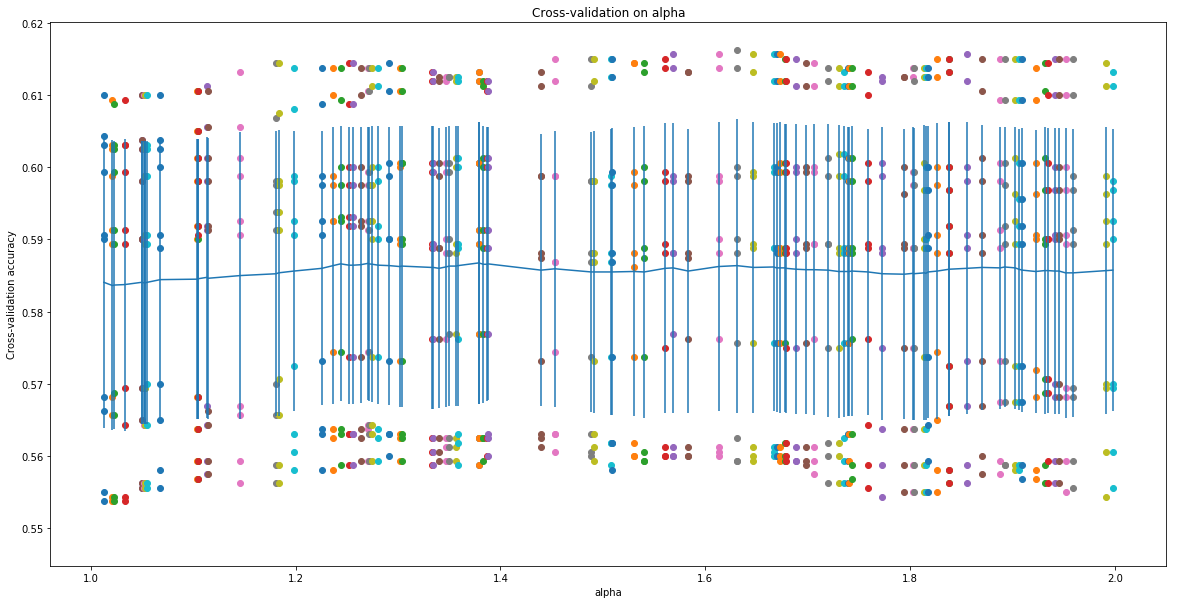

Best accuracy: 0.58675 at alpha = 1.37887714561


In [218]:
plt.figure(figsize=(20,10))
alpha_choices = sorted(alpha_choices)
# plot the raw observations
for alpha in alpha_choices:
    accuracies = alpha_acc[alpha]
    plt.scatter([alpha] * len(accuracies), accuracies)

# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = np.array([np.mean(v) for k,v in sorted(alpha_acc.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(alpha_acc.items())])
plt.errorbar(alpha_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on alpha')
plt.xlabel('alpha')
plt.ylabel('Cross-validation accuracy')
plt.show()

best_alpha = [k for k,v in sorted(alpha_acc.items())][np.argmax(accuracies_mean)]
print('Best accuracy:', np.max(accuracies_mean), 'at alpha =', best_alpha)

In [220]:
P_y, P_xy = train_NB(train_data_label, train_data_matrix, best_alpha)
train_data_pre = predict_NB(train_data_matrix, P_y, P_xy)
acc, precision, recall, f1 = evaluate(train_data_label, train_data_pre)
print("Evaluation: Accuracy: %f\tPrecision: %f\tRecall: %f\tMacro-F1: %f" % (acc, precision, recall, f1))

test_data_pre = predict_NB(test_data_matrix, P_y, P_xy)

sub_df = pd.DataFrame()
sub_df["id"] = test_id_list
sub_df["pred"] = test_data_pre
sub_df.to_csv("submission.csv", index=False)

Evaluation: Accuracy: 0.757875	Precision: 0.775028	Recall: 0.723816	Macro-F1: 0.744808


16034.0
apologising
[   16    20    29 ..., 18747 18756 18761]
[['great']]
[16034.0, 14367.0, 12709.0, 12533.0, 11961.0]


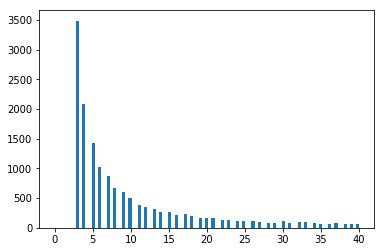

In [216]:
print(np.max(np.array(np.sum(train_data_matrix, axis=0)).flatten()))
print(list(vocab)[np.argmin(np.array(np.sum(train_data_matrix, axis=0)).flatten())])
print(np.argwhere(np.array(np.sum(train_data_matrix, axis=0)).flatten() <= 3).flatten())
print(np.array(list(vocab))[(np.argwhere(np.array(np.sum(train_data_matrix, axis=0)).flatten() >= 16034))])
print(sorted(np.array(np.sum(train_data_matrix, axis=0)).flatten())[::-1][0:5])
plt.hist(np.array(np.sum(train_data_matrix, axis=0)).flatten(), bins=np.linspace(0,40,100))
plt.show()